In [1]:
#2019 number of cars in London (thousands) [DfT VEH0204]
lon_car_2019=2661

# adoption rate of fuel type in GB yearly from 2001/2015 to 2020 [DfT VEH0253]
# number of newly registered vehicles of fuel type / total new registrations in that year
adop_car_p=[82.1,76.2,72.3,67.3,63.2,61.5,59.3,56.0,57.8,53.1,48.5,48.1,49.0,48.1,49.0,49.3,53.5,62.3,65.6,62.5]
adop_car_d=[17.8,23.7,27.5,32.6,36.6,38.1,40.0,43.2,41.4,45.7,50.3,50.5,49.5,49.8,48.2,47.4,41.8,31.4,26.3,18.9]
adop_car_h=[0]*3+[0.1,0.2,0.4,0.7,0.7,0.7,1.1,1.2,1.2,1.3,1.5,1.7,1.9,2.8,3.7,4.9,9.4]
adop_car_ph=[0]*13+[0.3,0.7,1.0,1.3,1.8,1.5,3.3]
adop_car_b=[0]*10+[0.1,0.1,0.1,0.3,0.4,0.4,0.5,0.7,1.6,5.8]

#2019 ages of cars in % of cars at given age starting from 0 to 30+ (i.e. 2019 to <1989)
car_per_age=[6.701865813,6.865554769,7.316778939,7.803457088,7.685096727,7.201434605,6.537954259,5.55890771,5.143852754,5.264539452,5.021894934,
     4.926460392,5.162837486,4.390143996,3.717893513,3.07826344,2.417367913,1.756067938,1.103872606,0.678520949,0.452388859,0.305495142,
     0.21615469,0.146699095,0.111399597,0.07995604,0.063239866,0.052973575,0.060591188,0.05324118,0.087805982]
#swap order of cars (oldest first) and put in decimal form
car_age=list(car_per_age[-i]/100 for i in range(0,31))

#average fuel consumption in litres per 100km for new cars registered from 1997 to 2019 [DfT ENV0103]
fuel_car_p=[8.3,8.3,8.1,8.0,7.9,7.8,7.7,7.6,7.5,7.4,7.2,7.0,6.5,6.3,6.1,5.8,5.6,5.5,5.4,5.4,5.5,5.6,5.7]
fuel_car_d=[7.0,6.9,6.6,6.3,6.2,6.1,6.2,6.2,6.2,6.3,6.2,5.9,5.7,5.5,5.2,5.0,4.9,4.7,4.6,4.5,4.6,4.9,5.1]

#kgC02 per litre of petrol and diesel
petrol=2.30176
diesel=2.65242

#km driven per year by cars & taxis in London from 1994 to 2019 (billion km) [DfT TRA0206]
km_lon=[25.9,25.8,26,26.1,26.2,26.8,26.5,26.3,26.3,25.7,25.4,25.1,24.8,24.4,23.9,23.9,24.7,24.5,24.6,24.7,25.4,25.6,25.7,26.3,27.3,28.1]

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

class Mathematics:
    """
    Creates straight and polynomial fit functions
    """
    def poly_fit(years,data,power):
        """
        Generate polynomial fit of given data.
        Inputs: x values (usually years), data, power (1 for linear, 2 for quadratic)
        """
        coeff = np.polyfit(years,data,power,cov=False)
        function=sp.poly1d(coeff)
        return(function)
    
    def straight_fit(x1,y1,x2,y2,f):
        """
        Straight fit between two points
        """
        m = (y2 - y1) / (x2 - x1)
        c = (y2 - (m * x2))
        return [i*m+c for i in f]

class Vehicle:
    """
    Creates vehicle object with emission properties
    """
    def __init__(self, fuel_type, age, mass, manufacture, elec):
        self.fuel_type = fuel_type
        self.age = age 
        self.m=mass
        self.c=manufacture
        self.e=elec
       
    def emissions(self,y):
        """
        Specifies the CO2 emissions intensity of every fuel type (g/km)
        """
        emissions_value=0
        phev_electric_emissions=0
        phev_tailpipe_emissions=0
        
        #if diesel
        if self.fuel_type==0:
            #[diesel]=kgCO2/l, [fuel consumption]=l/100km, so *10 gives [emissions]=g/km
            emissions_value=diesel*10*np.array(Fuel_Consumption(self.m).diesel()[self.age-1989])
        #if petrol
        if self.fuel_type==1:
            #[petrol]=kgCO2/l, [fuel consumption]=l/100km, so *10 gives [emissions]=g/km
            emissions_value=petrol*10*np.array(Fuel_Consumption(self.m).petrol()[self.age-1989])
        #if hybrid
        if self.fuel_type==2:
            #real-world PHEV utility factor of 39% as found by the ICCT
            phev_electric_emissions=0.39*np.array(Fuel_Consumption(self.m).bev()[self.age-1989])*10*np.array(Electricity(self.e).lca_emissions()[y-2010])
            phev_tailpipe_emissions=0.61*petrol*10*np.array(Fuel_Consumption(self.m).petrol()[self.age-1989])
        #if retrofitted ICEV (same emissions as BEV)
        if self.fuel_type==3:
            emissions_value=np.array(Fuel_Consumption(self.m).bev()[self.age-1989])*10*np.array(Electricity(self.e).lca_emissions()[y-2010])
        #if BEV
        if self.fuel_type==4:
            emissions_value=np.array(Fuel_Consumption(self.m).bev()[self.age-1989])*10*np.array(Electricity(self.e).lca_emissions()[y-2010])

        return emissions_value,phev_electric_emissions,phev_tailpipe_emissions
    
    def prod_emissions(self,y):
        """
        Specifies the production emissions of each type of vehicle (kgco2)
        Consists of emissions from manufacturing + end-of-life emissions + emissions change with mass + emissions of road construction
        22% of car production gets decarbonised with electrical grid
        """
        emissions_value=0
        #if diesel
        if self.fuel_type==0:
            emissions_value=3303+((self.m-1400)/1400)*0.73*4235+(15334/3.6)*Electricity(self.e).lca_emissions()[y-2010]+3447
        #if petrol
        if self.fuel_type==1:
            emissions_value=3303+((self.m-1400)/1400)*0.73*4235+(15334/3.6)*Electricity(self.e).lca_emissions()[y-2010]+3447
        #if hybrid
        if self.fuel_type==2:
            #Non-regulated manufacturing
            if self.c==0:
                emissions_value=15000+((self.m-1400)/1400)*0.67*15000+3447
            #Regulated manufacturing
            elif self.c==1:
                emissions_value=4320+((self.m-1400)/1400)*0.67*5538+(18766/3.6)*Electricity(self.e).lca_emissions()[y-2010]+3447
        #if retrofit
        if self.fuel_type==3:
            #Non-regulated manufacturing
            if self.c==0:
                emissions_value=8043+3447
            #Regulated manufacturing
            elif self.c==1:
                emissions_value=3385+(10636/3.6)*Electricity(self.e).lca_emissions()[y-2010]+3447
        #if BEV
        if self.fuel_type==4:
            #Non-regulated manufacturing
            if self.c==0:
                emissions_value=15000+((self.m-1400)/1400)*0.67*15000+3447
            #Regulated manufacturing
            elif self.c==1:
                emissions_value=6784+((self.m-1400)/1400)*0.67*8698+(21318/3.6)*Electricity(self.e).lca_emissions()[y-2010]+3447   
                
        return emissions_value
    
    def prod_energy(self):
        """
        Specifies the production energy of each type of vehicle
        """
        #in MJ per car
        #manufacturing + endoflife energy + energy change with mass + energy of road construction
        energy_value=0
        #if diesel
        if self.fuel_type==0:
            #Non-regulated manufacturing
            if self.c==0:
                energy_value=75700+((self.m-1400)/1400)*0.8*75700+87362
            #Regulated manufacturing
            if self.c==1:
                energy_value=69700+((self.m-1400)/1400)*0.8*69700+87362
        #if petrol
        if self.fuel_type==1:
            #Non-regulated manufacturing
            if self.c==0:
                energy_value=75700+((self.m-1400)/1400)*0.8*75700+87362
            #Regulated manufacturing
            if self.c==1:
                energy_value=69700+((self.m-1400)/1400)*0.8*69700+87362
        #if hybrid
        if self.fuel_type==2:
            #Non-regulated manufacturing
            if self.c==0:
                energy_value=90300+((self.m-1400)/1400)*0.75*90300+87362
            #Regulated manufacturing
            if self.c==1:
                energy_value=85300+((self.m-1400)/1400)*0.75*85300+87362
        #if retrofit
        if self.fuel_type==3:
            energy_value=50000+87362
        #if BEV
        if self.fuel_type==4:
            #Non-regulated manufacturing
            if self.c==0:
                energy_value=100000+((self.m-1400)/1400)*0.75*100000+87362
            #Regulated manufacturing
            if self.c==1:
                energy_value=96900+((self.m-1400)/1400)*0.75*96900+87362
        return energy_value
    
class ModalShift:
    """
    Finds emissions and energy intensity of non-car modes
    """
    #non car modal share for london
    modal_walk=[0.39]*31
    modal_cycle=[0.04]*31
    modal_bus=[0.22]*31
    modal_rail=[0.35]*31
    modal_ferry=[0]*31
    
    def co2intensity(elec):
        """
        CO2 intensity of non-car modes
        Can adjust modal shares and emissions intensities (e.g. due to changing occupancies) to find lower emissions
        """
        
        #kgco2-eq per passenger kilometer transport (pkt)
        #values based on sustainability paper sustainability-650843-SI
        co2walk=[0.00025]*31
        co2cycle=[0.0094]*31
        #at bus occupancy of 20
        #keeping emissions from manufacture and infrastructure relatively fixed 
        #emissions from energy use per km is straight line between 2020 co2 value and 2050 100% electricity value
        co2bus=np.array([0.023]*31)+Mathematics.straight_fit(2019,0.088,2050, \
                                                             0.319*Electricity(elec).lca_emissions()[-1],range(2020,2051))
        #use electricity values for 2020 and 2050
        co2rail=np.array([0.013]*31)+Mathematics.straight_fit(2019,0.15*Electricity(elec).lca_emissions()[10],2050, \
                                                             0.15*Electricity(elec).lca_emissions()[-1],range(2020,2051))
        
        avg=np.array(ModalShift.modal_walk)*np.array(co2walk)+np.array(ModalShift.modal_cycle)*np.array(co2cycle) \
            +np.array(ModalShift.modal_bus)*np.array(co2bus)+np.array(ModalShift.modal_rail)*np.array(co2rail)
        return avg
    
    def energy():
        """
        Energy intensity of non-car modes
        """
        
        #MJ per passenger kilometer transport (pkt)
        #values based on sustainability paper [sustainability-650843-SI]
        walk=[0.007]*31
        cycle=[0.1524]*31
        #at bus occupancy of 20
        bus=[1.42]*31
        #at train occupancy of 146/200
        rail=[0.751]*31
        
        avg=np.array(ModalShift.modal_walk)*np.array(walk)+np.array(ModalShift.modal_cycle)*np.array(cycle) \
            +np.array(ModalShift.modal_bus)*np.array(bus)+np.array(ModalShift.modal_rail)*np.array(rail)
        return avg
        
class Adoption_Rate:
    """
    Calculates adoption rates (percentage of new cars sold of a specific fuel type) from 1989 to 2050
    Takes hisotrical data and estimates furture rates
    """
    def __init__(self,phase_out_date,phase_out_hybrid):
        self.p=phase_out_date
        self.ph=phase_out_hybrid
        
    def adoption_bev(self):
        """
        Adoption of Battery-Electric Cars is the difference between 100% and all other fuel types
        """
        adoption_bev=[]
        adoption_diesel=Adoption_Rate(self.p,self.ph).adoption_diesel()
        adoption_petrol=Adoption_Rate(self.p,self.ph).adoption_petrol()
        adoption_hybrid=Adoption_Rate(self.p,self.ph).adoption_hybrid()
        adoption_plugin=Adoption_Rate(self.p,self.ph).adoption_plugin()
        
        for i in range(0,62):
            adoption_bev.append(100-adoption_diesel[i]-adoption_petrol[i]-adoption_hybrid[i]-adoption_plugin[i])
        return(adoption_bev)
    
        
    def adoption_diesel(self):
        """
        Creates list of adoption rates of diesel cars from 1989 to 2050 in percentage
        Assumes linear decrease from historical data
        """
        diesel_increase=Mathematics.poly_fit([2001,2002,2003],adop_car_d[0:3],1)
        diesel_decrease=Mathematics.poly_fit([2017,2018,2019,2020],adop_car_d[16:],1)
        
        adoption_diesel=np.append(np.append(np.append([0]*9,diesel_increase(range(1998,2004))),adop_car_d[3:-4]),np.append(diesel_decrease(range(2017,2023)),[0]*28))
        return(adoption_diesel)

    def adoption_plugin(self):
        """
        Plug-in hybrid phase-out date can only take values 2025,2030,2035,2040
        Consists of a gaussian that peaks and drop back to zero at the phase-out date
        """
        
        x=np.linspace(2020,self.ph-1,self.ph-2021)
        
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
        if self.ph==2025:
            adoption_plugin=np.append(np.append(np.append([0]*12,adop_car_ph),10*gaussian(x,2020+(self.ph-2020)/2,5)),[0]*(2050-self.ph+1))
        elif self.ph==2030:
            adoption_plugin=np.append(np.append(np.append([0]*12,adop_car_ph),15*gaussian(x,2020+(self.ph-2020)/2,4)),[0]*(2050-self.ph+1))
        elif self.ph==2035:
            adoption_plugin=np.append(np.append(np.append([0]*12,adop_car_ph),20*gaussian(x,2020+(self.ph-2020)/2,6)),[0]*(2050-self.ph+1))
        elif self.ph==2040:
            adoption_plugin=np.append(np.append(np.append([0]*12,adop_car_ph),25*gaussian(x,2020+(self.ph-2020)/2,7)),[0]*(2050-self.ph+1))
        else:
            adoption_plugin=np.append(np.append(np.append([0]*12,adop_car_ph),15*gaussian(x,2020+(self.ph-2020)/2,5)),[0]*(2050-self.ph+1))
        return(adoption_plugin)
    
    def adoption_hybrid(self):
        """
        Hybrid phase-out date can only take values 2025,2030,2035,2040
        Consists of a gaussian that peaks and drop back to zero at the phase-out date
        """
              
        x=np.linspace(2020,self.p,self.p-2021)
        
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
        if self.p==2025:
            adoption_hybrid=np.append(np.append(np.append([0]*12,np.array(adop_car_h)),15*gaussian(x,2020+(self.p-2020)/2,6)),[0]*(2050-self.p+1))
        elif self.p==2030:
            adoption_hybrid=np.append(np.append(np.append([0]*12,np.array(adop_car_h)),20*gaussian(x,2020+(self.p-2020)/2,6)),[0]*(2050-self.p+1))
        elif self.p==2035:
            adoption_hybrid=np.append(np.append(np.append([0]*12,np.array(adop_car_h)),25*gaussian(x,2020+(self.p-2020)/2,7)),[0]*(2050-self.p+1))
        elif self.p==2040:
            adoption_hybrid=np.append(np.append(np.append([0]*12,np.array(adop_car_h)),30*gaussian(x,2020+(self.p-2020)/2,9)),[0]*(2050-self.p+1))
        else:
            adoption_hybrid=np.append(np.append(np.append([0]*12,np.array(adop_car_h)),20*gaussian(x,2020+(self.p-2020)/2,6)),[0]*(2050-self.p+1))    
        return(adoption_hybrid)
    
    def adoption_petrol(self):
        """
        Assumes 100% adoption rate, until historical data, then linear decrease from 2020 to 0 at phase-out date
        """
        decline=Mathematics.straight_fit(2020,adop_car_p[-1],self.p,0,range(2021,self.p))
        diesel_increase=[100]*3-np.array(Mathematics.poly_fit([2001,2002,2003],adop_car_d[0:3],1)(range(1998,2001)))
        adoption_petrol=np.append(np.append(np.append(np.append([100]*9,diesel_increase),adop_car_p),decline),[0]*(2050-self.p+1))
        return(adoption_petrol)

class Fuel_Consumption:
    """
    Calculates fuel consumption of petrol, diesel and hybrid cars, and the emissions intensity of the electrical grid
    """
    
    def __init__(self,mass):
        """
        Initialises class with mass parameter
        """
        self.m=mass
        
    def petrol(self):
        #takes average fuel consumption of petrol cars every year and calculates increase/decrease due to lightweighting policies
        pre_1997=Mathematics.poly_fit([1997,1998,1999],fuel_car_p[0:3],1)
        post_2020=np.append(Mathematics.straight_fit(2020,fuel_car_p[-1],2025,fuel_car_p[-1]+(self.m-1400)*0.0032,range(2020,2026)),
                            [fuel_car_p[-1]+(self.m-1400)*0.0032]*25)
        return np.append(pre_1997(range(1989,2000)),np.append(fuel_car_p[3:],post_2020))
        
    def diesel(self):
        #takes average fuel consumption of diesel cars every year and calculates increase/decrease due to lightweighting policies
        pre_1997=Mathematics.poly_fit([1997,1998,1999],fuel_car_d[0:3],1)
        post_2020=np.append(Mathematics.straight_fit(2020,fuel_car_d[-1],2025,fuel_car_d[-1]+(self.m-1400)*0.0028,range(2020,2026)),
                            [fuel_car_d[-1]+(self.m-1400)*0.0028]*25)
        return np.append(pre_1997(range(1989,2000)),np.append(fuel_car_d[3:],post_2020))
    
    def bev(self):
        #takes average fuel consumption of BEVs every year and calculates increase/decrease due to lightweighting policies
        bev=np.append([18]*31,np.append(Mathematics.straight_fit(2020,18,2025,18+(self.m-1400)*0.01,range(2020,2026)),[18+(self.m-1400)*0.01]*25))
        return(bev)
    

class Electricity:
    """
    Calculates life cycle electricity generation emissions, average efficiency of electric grid, percentage of renewables in grid,
    
    """
    
    #assumptions for energy mix values, in percentage of total electricity generation
    #each element in array represents a different time-step
    #default (2050 net-zero case) is each element 1 decade apart starting from 2010
    coal=np.array([28,2,0,0,0])
    gas=np.array([47,35,21,10,0])
    wind=np.array([3,25,42,47,51])
    nuclear=np.array([15,17,18,19,20])
    solar=np.array([0,4,10,15,20])
    bioenergy=np.array([3,7,7,7,7])
    hydro=np.array([1,2,2,2,2])
    other=np.array([3,8,0,0,0])
    storage=(wind+solar)*0.15
    
    def __init__(self,elec):
        """
        Initialises class with net-zero electricity generation date
        """
        self.e=elec   
        
    def lca_emissions(self):
        #calculates the life cycle electricity generation emissions every year from 2010 to 2051
        #sum of electricity generation and transmission infrastructure emissions
        
        avg_lca=(np.array(Electricity.coal)*980+np.array(Electricity.gas)*670+np.array(Electricity.wind)*10+np.array(Electricity.nuclear)*12\
        +np.array(Electricity.solar)*45+np.array(Electricity.bioenergy)*29+np.array(Electricity.hydro)*31+np.array(Electricity.other)*500)/100\
        +Electricity.storage/100*43
        
        division=int((self.e-2020)/3)
        
        #lcaemissions in gco2/kwh
        if self.e<2050:
            projection1=Mathematics.straight_fit(2010,avg_lca[0],2020,avg_lca[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,avg_lca[1],2020+division,avg_lca[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,avg_lca[2],2020+division*2,avg_lca[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,avg_lca[3],2020+division*3,avg_lca[4],range(2020+division*2,2020+division*3))
            projection5=Mathematics.straight_fit(2020+division*3,avg_lca[4],2050,avg_lca[4],range(2020+division*3,2051))
            lcaemissions=(np.append(np.append(np.append(np.append(projection1,projection2),projection3),projection4),projection5))+0.011
        #the case for 100% renewable electricity generation for electric vehicles
        elif self.e==2020:
            lcaemissions=np.array([avg_lca[4]]*41)+0.011
        else:
            projection1=Mathematics.straight_fit(2010,avg_lca[0],2020,avg_lca[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,avg_lca[1],2020+division,avg_lca[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,avg_lca[2],2020+division*2,avg_lca[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,avg_lca[3],2020+division*3,avg_lca[4],range(2020+division*2,2051))
            lcaemissions=(np.append(np.append(np.append(projection1,projection2),projection3),projection4))+0.011
   
        return lcaemissions/1000

    def avg_efficiency(self):
        #calculates average efficiency of electrical grid from 2010 to 2051
        
        avg_efficiency=(np.array(Electricity.coal)*32.1+np.array(Electricity.gas)*48.3+np.array(Electricity.wind)*97.3+np.array(Electricity.nuclear)*40.3\
        +np.array(Electricity.solar)*97.3+np.array(Electricity.bioenergy)*34.7+np.array(Electricity.hydro)*99.6+np.array(Electricity.other)*64.2)/100
        
        division=int((self.e-2020)/3)
        
        #avg efficiency in %
        if self.e<2050:
            projection1=Mathematics.straight_fit(2010,avg_efficiency[0],2020,avg_efficiency[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,avg_efficiency[1],2020+division,avg_efficiency[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,avg_efficiency[2],2020+division*2,avg_efficiency[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,avg_efficiency[3],2020+division*3,avg_efficiency[4],range(2020+division*2,2020+division*3))
            projection5=Mathematics.straight_fit(2020+division*3,avg_efficiency[4],2050,avg_efficiency[4],range(2020+division*3,2051))
            avgefficiency=(np.append(np.append(np.append(np.append(projection1,projection2),projection3),projection4),projection5))
        elif self.e==2020:
            avgefficiency=np.array([avg_efficiency[4]]*41)
        else:
            projection1=Mathematics.straight_fit(2010,avg_efficiency[0],2020,avg_efficiency[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,avg_efficiency[1],2020+division,avg_efficiency[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,avg_efficiency[2],2020+division*2,avg_efficiency[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,avg_efficiency[3],2020+division*3,avg_efficiency[4],range(2020+division*2,2051))
            avgefficiency=(np.append(np.append(np.append(projection1,projection2),projection3),projection4))
   
        return avgefficiency/100
        
    def ren_percentage(self):
        #calculates percentage of renewables (wind and solar) in grid
        
        renewables=Electricity.wind+Electricity.solar
        
        division=int((self.e-2020)/3)
        
        if self.e<2050:
            projection1=Mathematics.straight_fit(2010,renewables[0],2020,renewables[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,renewables[1],2020+division,renewables[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,renewables[2],2020+division*2,renewables[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,renewables[3],2020+division*3,renewables[4],range(2020+division*2,2020+division*3))
            projection5=Mathematics.straight_fit(2020+division*3,renewables[4],2050,renewables[4],range(2020+division*3,2051))
            ren_perc=(np.append(np.append(np.append(np.append(projection1,projection2),projection3),projection4),projection5))
        elif self.e==2020:
            ren_perc=np.array([renewables[4]]*41)
        else:
            projection1=Mathematics.straight_fit(2010,renewables[0],2020,renewables[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,renewables[1],2020+division,renewables[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,renewables[2],2020+division*2,renewables[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,renewables[3],2020+division*3,renewables[4],range(2020+division*2,2051))
            ren_perc=(np.append(np.append(np.append(projection1,projection2),projection3),projection4))
        
        return ren_perc/100
        
    def avg_eroi(self):
        #calculates average EROI of electricity generation sources to find embedded energy
        
        avg_eroi=(np.array(Electricity.coal)*46+np.array(Electricity.gas)*20+np.array(Electricity.wind)*20+np.array(Electricity.nuclear)*14\
        +np.array(Electricity.solar)*10+np.array(Electricity.bioenergy)*5+np.array(Electricity.hydro)*84+np.array(Electricity.other)*34)/100
        
        division=int((self.e-2020)/3)
        
        #avg efficiency in %
        if self.e<2050:
            projection1=Mathematics.straight_fit(2010,avg_eroi[0],2020,avg_eroi[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,avg_eroi[1],2020+division,avg_eroi[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,avg_eroi[2],2020+division*2,avg_eroi[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,avg_eroi[3],2020+division*3,avg_eroi[4],range(2020+division*2,2020+division*3))
            projection5=Mathematics.straight_fit(2020+division*3,avg_eroi[4],2050,avg_eroi[4],range(2020+division*3,2051))
            avgeroi=(np.append(np.append(np.append(np.append(projection1,projection2),projection3),projection4),projection5))
        elif self.e==2020:
            avgeroi=np.array([avg_eroi[4]]*41)+0.011
        else:
            projection1=Mathematics.straight_fit(2010,avg_eroi[0],2020,avg_eroi[1],range(2010,2020))
            projection2=Mathematics.straight_fit(2020,avg_eroi[1],2020+division,avg_eroi[2],range(2020,2020+division))
            projection3=Mathematics.straight_fit(2020+division,avg_eroi[2],2020+division*2,avg_eroi[3],range(2020+division,2020+division*2))
            projection4=Mathematics.straight_fit(2020+division*2,avg_eroi[3],2020+division*3,avg_eroi[4],range(2020+division*2,2051))
            avgeroi=(np.append(np.append(np.append(projection1,projection2),projection3),projection4))
   
        return avgeroi

        
class Distance_Driven:
    """
    Calculates distance driven by average car by dividing total km driven by whole fleet with number of fleet from data
    """
    def __init__(self,miles_driven,rate):
        """
        Initialises class with distance driven parameter
        """
        self.md=miles_driven
        self.r=rate
    
    def Lon(self):
        end=2022+self.r 
        #rate of modal shift determined by the number of years the modal shift happens over r (starting from 2022)
        preprojection=Mathematics.straight_fit(2020,km_lon[-1],2022,km_lon[-1],range(2020,2022))
        projection=Mathematics.straight_fit(2022,km_lon[-1],end,km_lon[-1]*(1+self.md/100),range(2022,end+1))
        postprojection=Mathematics.straight_fit(end,km_lon[-1]*(1+self.md/100),2052,km_lon[-1]*(1+self.md/100),range(end+1,2052))
        return np.append(np.append(np.append(np.array(km_lon),preprojection),projection),postprojection)

In [3]:
def initialise_fleet(p,ph,m,fs,md,c,e):
    """
    Generate a model car fleet for the year 2019 based on 2019 data.
    """
    
    car_fleet_size=lon_car_2019
    
    #find adoption rates of fuel types
    adoption_diesel=Adoption_Rate(p,ph).adoption_diesel()
    adoption_bev=Adoption_Rate(p,ph).adoption_bev()
    adoption_plugin=Adoption_Rate(p,ph).adoption_plugin()
    adoption_petrol=Adoption_Rate(p,ph).adoption_petrol()+Adoption_Rate(p,ph).adoption_hybrid()
    
    car_list=[]
    
    #to avoid small number of cars aged 20-30+ skewing model results from scrapping, remove these from list
    #cut first 10 years of car age and distribute proportionally on all other years
    new_car_age=list(car_age[i]/sum(car_age[10:]) for i in range(10,31))
    
    #for every year of manufacture i.e. 1999 to 2019 (21 years)
    for i in range(0,len(new_car_age)):
        dcount=0
        bcount=0
        pcount=0
        hcount=0
        
        #make diesel cars (fuel type 0)
        # % of cars that age * 2019 car fleet size * adoption of diesel cars that year /100 
        for j in range(0,int(new_car_age[i]*car_fleet_size*adoption_diesel[i]/100)):
            c=Vehicle(fuel_type=0,age=(1999+i),mass=m,manufacture=c,elec=e)
            car_list.append(c)
            dcount=dcount+1
            
        #make petrol fuel type 1
        for j in range(0,int(new_car_age[i]*car_fleet_size*adoption_petrol[i]/100)):
            c=Vehicle(fuel_type=1,age=(1999+i),mass=m,manufacture=c,elec=e)
            car_list.append(c)
            pcount=pcount+1    
        
        #make plug-in hybrid fuel type 2
        for j in range(0,int(new_car_age[i]*car_fleet_size*adoption_plugin[i]/100)):
            c=Vehicle(fuel_type=2,age=(1999+i),mass=m,manufacture=c,elec=e)
            car_list.append(c)
            hcount=hcount+1
        
        #make bev fuel type 4
        for j in range(0,int(new_car_age[i]*car_fleet_size*adoption_bev[i]/100)):
            c=Vehicle(fuel_type=4,age=(1999+i),mass=m,manufacture=c,elec=e)
            car_list.append(c)
            bcount=bcount+1
               
        #print('year:',1989+i,'petrol cars:', pcount,'diesel cars:', dcount,'bev cars:',bcount,'phev cars:',hcount)
        
    #print('all cars=',len(car_list))
    #print('petrol&hybrid=',sum(p.fuel_type == 1 for p in car_list))
    #print('diesel=',sum(p.fuel_type == 0 for p in car_list))
    #print('bev=',sum(p.fuel_type == 4 for p in car_list))
    #print('plug-in hybrid=',sum(p.fuel_type == 2 for p in car_list))
    
    return car_list

In [4]:
def evolve_fleet(p,ph,g1,g2,m,fs,md,rf,c,e,r):
    """
    Take 2019 model car fleet and evolve fleet year-on-year, based on policy parameters
    """
    
    #create car list from vehicle initialisation class sorted by year of manufacture in ascending order (oldest cars first)
    car_list=initialise_fleet(p,ph,m,fs,md,c,e) 
    
    total_cars=[]
    bev_cars=[]
    petrol_cars=[]
    diesel_cars=[]
    plugin_cars=[]
    conv_cars=[]
    ages=[]
    demand_difference=[]
    electric_emiss=[]
    tailpipe_emiss=[]
    ev_prod_emissions=[]
    ice_prod_emissions=[]
    conv_prod_emissions=[]
    elec_demand=[]
    foss_demand=[]
    ev_prod_energy=[]
    ice_prod_energy=[]
    conv_prod_energy=[]
    km_driven=[]
    
    #find future fleet size using user input for % increase from fleet size in 2019 to 2041 levels
    fleetsize=np.append(Mathematics.straight_fit(2019,lon_car_2019,2041,lon_car_2019*(1+fs/100),range(2020,2041)),[lon_car_2019*(1+fs/100)]*11)
 
    #for evolution of fleet from 2020 to 2050
    for i in range(0,31):

        #find age distribution of cars 
        age_list=[(2020+i-x.age) for x in car_list]
        ages.append(age_list)
        
        before_removal=len(car_list)
        
        #count number of ICE cars removed
        ice_count=0
        
        #remove cars based on a grandfathering policy
        #EVs have default lifetime of 20 years, whereas ICEVs have variable lifetimes set by g1 (cars made prior to 2020) 
        #and g2 (cars made post 2020)
        #save non-scrapped cars in new car list                
        car_list2=[]
        for j in range(0,len(car_list)):
            #for BEV cars, lifetime is 20 years
            if car_list[j].fuel_type==4:
                if car_list[j].age>=2020+i-20:
                    car_list2.append(car_list[j])
            #for retrofitted cars, lifetime is 10 years longer than normal ICE scrapping age (post-2020)
            elif car_list[j].fuel_type==3:
                if car_list[j].age>=2020+i-g2-10:
                        car_list2.append(car_list[j])
            #for petrol, diesel and plug-in hybrid, lifetime is set by scrap ages g1 and g2
            else: 
                if car_list[j].age<2020:
                    #for cars made prior to 2020, allow a longer age set by g1
                    if car_list[j].age>=2020+i-g1:
                        car_list2.append(car_list[j])
                    else:
                        if car_list[j].fuel_type==0:
                            ice_count=ice_count+1
                        if car_list[j].fuel_type==1:
                            ice_count=ice_count+1    
                else:
                    #for cars made post 2020, make scrap policy happen earlier set by g2
                    if car_list[j].age>=2020+i-g2:
                        car_list2.append(car_list[j])
                    else:
                        if car_list[j].fuel_type==0:
                            ice_count=ice_count+1
                        if car_list[j].fuel_type==1:
                            ice_count=ice_count+1                   
                    
        car_list=car_list2
        after_removal=len(car_list)
        
        #find number of new cars needed to satisfy total fleet size
        #fleet size in year n+1 - number of cars in list after cars have been scrapped
        new_cars=fleetsize[i+1]-after_removal
        
        #making new cars
        if new_cars>0:
            #X% of old fossil fuel cars are retrofitted, depending on retrofit input
            #if there are more new cars than ICEV cars removed, retrofit X% of ICEV cars 
            if new_cars-ice_count>=0:
                new_conv=int(rf*ice_count)
            #if there are less new cars than ICEV cars removed, retrofit X% of the number of new cars
            if new_cars-ice_count<0:
                new_conv=int(rf*new_cars)
            
            #calculate how many new cars of each type based on adoption rates
            rest_of_cars=new_cars-new_conv
            new_BEV=int(Adoption_Rate(p,ph).adoption_bev()[i+30]/100*rest_of_cars)
            new_diesel=int(Adoption_Rate(p,ph).adoption_diesel()[i+30]/100*rest_of_cars)
            new_plugin=int(Adoption_Rate(p,ph).adoption_plugin()[i+30]/100*rest_of_cars)
            new_petrol=int((Adoption_Rate(p,ph).adoption_petrol()[i+30]/100+Adoption_Rate(p,ph).adoption_hybrid()[i+30]/100)*rest_of_cars)
            
            #make cars based on adoption rate* new cars
            for j in range(0,new_BEV):
                car=Vehicle(fuel_type=4,age=2020+i,mass=m,manufacture=c,elec=e)
                car_list.append(car)
            for j in range(0,new_petrol):
                car=Vehicle(fuel_type=1,age=2020+i,mass=m,manufacture=c,elec=e)
                car_list.append(car)
            for j in range(0,new_diesel):
                car=Vehicle(fuel_type=0,age=2020+i,mass=m,manufacture=c,elec=e)
                car_list.append(car)
            for j in range(0,new_plugin):
                car=Vehicle(fuel_type=2,age=2020+i,mass=m,manufacture=c,elec=e)
                car_list.append(car)
            for j in range(0,new_conv):
                car=Vehicle(fuel_type=3,age=2020+i,mass=m,manufacture=c,elec=e)
                car_list.append(car)
            
            
        count=0    
        #if more cars need to be removed due to a modal shift, then remove oldest diesel, then petrol, then plug-in hybrid cars
        if new_cars<0:
            car_list.sort(key=lambda x: x.age, reverse=False)
            car_list.sort(key=lambda x: x.fuel_type, reverse=False)
            del car_list[0:-int(new_cars)]
            
        #print('fleetsize[i+1]',fleetsize[i+1],'fleetsize[i]',fleetsize[i])
        
        #print('year=',2020+i,'new cars=',new_cars, 'new bevs=', new_BEV, 'new petrol=',new_petrol, 'new diesel', new_diesel, 'new plugin', new_plugin)
            
        #find number of cars for plotting
        total_cars.append(len(car_list))
        bev_cars.append(sum(p.fuel_type == 4 for p in car_list))
        petrol_cars.append(sum(p.fuel_type==1 for p in car_list))
        diesel_cars.append(sum(p.fuel_type==0 for p in car_list))
        plugin_cars.append(sum(p.fuel_type==2 for p in car_list))
        conv_cars.append(sum(p.fuel_type==3 for p in car_list))
        
        #find difference in distance driven in baseline (business-as-usual case) and modally shifted case
        #in order to calculate modal shift emissions
        demand_diff=Distance_Driven(20,28).Lon()[i+26]*1000000000-Distance_Driven(md,r).Lon()[i+26]*1000000000
        if demand_diff>0:
            demand_difference.append(demand_diff)
        if demand_diff<=0:
            demand_difference.append(0)
        
        #dist=distance driven by each cars in that year
        dist=Distance_Driven(md,r).Lon()[i+26]*1000000000/len(car_list)
        
        #create arrays
        electric_emissions=[]
        tailpipe_emissions=[]
        ice_production_emissions=[]
        ev_production_emissions=[]
        ice_production_energy=[]
        ev_production_energy=[]
        conv_production_emissions=[]
        conv_production_energy=[]
        elec_demand_yearly=[]
        foss_demand_yearly=[]
        kilometres=[]
        
        #for every car in list
        for j in range(0,len(car_list)):
            kilometres.append(dist)
            
            #add emissions from that car to yearly list (emissions=carbon intensity*distance driven)
            
            if car_list[j].fuel_type==0:
                #diesel
                #MJ of fossil fuel energy (l/km fuel consumption*energy density of fuel*km driven)
                foss_demand_yearly.append(Fuel_Consumption(m).diesel()[car_list[j].age-1989]/100*36.9*dist)
                #emissions in gCO2e
                tailpipe_emissions.append(car_list[j].emissions(2020+i)[0]*dist)
                
            if car_list[j].fuel_type==1:
                #petrol
                foss_demand_yearly.append(Fuel_Consumption(m).petrol()[car_list[j].age-1989]/100*33.7*dist)
                tailpipe_emissions.append(car_list[j].emissions(2020+i)[0]*dist)
            
            if car_list[j].fuel_type==2:
                #phev
                #utility factor of 39% as found by the ICCT
                #combination of BEV and petrol energy consumption/emissions
                elec_demand_yearly.append(0.39*(Fuel_Consumption(m).bev()[i+30]/100*dist+Fuel_Consumption(m).bev()[i+30]/100*dist*1.36/3.6))
                electric_emissions.append(car_list[j].emissions(2020+i)[1]*dist+0.39*Fuel_Consumption(m).bev()[i+30]/100*dist*94.06)
                foss_demand_yearly.append(0.61*Fuel_Consumption(m).petrol()[car_list[j].age-1989]/100*33.7*dist)
                tailpipe_emissions.append(car_list[j].emissions(2020+i)[2]*dist)
            
            if car_list[j].fuel_type==3:
                #retroffited ICEV, now acts as BEV
                elec_demand_yearly.append(Fuel_Consumption(m).bev()[i+30]/100*dist+Fuel_Consumption(m).bev()[i+30]/100*dist*1.36/3.6)
                electric_emissions.append(car_list[j].emissions(2020+i)[0]*dist+Fuel_Consumption(m).bev()[i+30]/100*dist*94.06)

            if car_list[j].fuel_type==4:
                #BEV
                #energy consumption of EV driving + energy demand for ev charging point infrastructure (in kwh)
                elec_demand_yearly.append(Fuel_Consumption(m).bev()[i+30]/100*dist+Fuel_Consumption(m).bev()[i+30]/100*dist*1.36/3.6)
                #emissions in gCO2e
                #emissions from driving EVs + emissions from EV charging infrastructure
                electric_emissions.append(car_list[j].emissions(2020+i)[0]*dist+Fuel_Consumption(m).bev()[i+30]/100*dist*94.06)
            
            #for cars made in this year, add the embedded emissions from manufacture+end-of-life
            if car_list[j].age==(2020+i):
                if car_list[j].fuel_type==0:
                    ice_production_emissions.append(car_list[j].prod_emissions(2020+i)*1000)
                    ice_production_energy.append(car_list[j].prod_energy()*1000)
                if car_list[j].fuel_type==1:
                    ice_production_emissions.append(car_list[j].prod_emissions(2020+i)*1000)
                    ice_production_energy.append(car_list[j].prod_energy()*1000)
                if car_list[j].fuel_type==2:
                    ev_production_emissions.append(car_list[j].prod_emissions(2020+i)*1000)
                    ev_production_energy.append(car_list[j].prod_energy()*1000)
                if car_list[j].fuel_type==3:
                    conv_production_emissions.append(car_list[j].prod_emissions(2020+i)*1000)
                    conv_production_energy.append(car_list[j].prod_energy()*1000)
                if car_list[j].fuel_type==4:
                    ev_production_emissions.append(car_list[j].prod_emissions(2020+i)*1000)
                    ev_production_energy.append(car_list[j].prod_energy()*1000)
                
        
        km_driven.append(sum(kilometres))
        electric_emiss.append(sum(electric_emissions))
        tailpipe_emiss.append(sum(tailpipe_emissions))
        ev_prod_emissions.append(sum(ev_production_emissions))
        ice_prod_emissions.append(sum(ice_production_emissions))
        conv_prod_emissions.append(sum(conv_production_emissions))
        ev_prod_energy.append(sum(ev_production_energy))
        ice_prod_energy.append(sum(ice_production_energy))
        conv_prod_energy.append(sum(conv_production_energy))
        #electricity demand in kwh
        elec_demand.append(sum(elec_demand_yearly))
        #fossil fuel energy demand in MJ
        foss_demand.append(sum(foss_demand_yearly))
    
    avg_energy_efficiency=Electricity(e).avg_efficiency()
    avg_eroi=Electricity(e).avg_eroi()
    ren_perc=Electricity(e).ren_percentage()
    avg_renewable_efficiency=97.3/100
    storage_eroi=4
    
    #energy demand = electricity demand divided by the overall efficiency of the grid, plus embedded energy over EROI
    elec_en_demand=np.array(elec_demand)*3.6/np.array(avg_energy_efficiency)[10:]+\
    ((np.array(elec_demand)*3.6/np.array(avg_energy_efficiency)[10:]))/np.array(avg_eroi)[10:]+\
    (((np.array(elec_demand)*3.6*0.15*np.array(ren_perc)[10:]/100)/avg_renewable_efficiency))/storage_eroi
        
    #calculate emissions from modal shift
    co2intensity=ModalShift.co2intensity(e)
    mod_energy=ModalShift.energy()
    #average occupancy of car is 1.6, so calculate modal shift emissions for every passenger 
    mod_shift_emiss=np.array(demand_difference)*1.6*np.array(co2intensity)/1000000000
    mod_shift_energy=np.array(demand_difference)*1.6*np.array(mod_energy)    
  
    return(total_cars,bev_cars,petrol_cars,diesel_cars,plugin_cars,conv_cars,ages,electric_emiss,tailpipe_emiss,mod_shift_emiss,elec_en_demand,foss_demand,mod_shift_energy,ev_prod_emissions,ice_prod_emissions,conv_prod_emissions,ev_prod_energy,ice_prod_energy,conv_prod_energy,km_driven)

In [5]:
def Run_Model(phase_out_date,phase_out_hybrid,scrap_age_pre2020,scrap_age_post2020,mass,\
                fleet_size_projection,miles_driven_projection,retrofit_percentage,manufacture,elec,rate):
    
    #Run evolve fleet function with parameters given
    total,bev,petrol,diesel,hybrid,conv,ages,electric_emissions,tailpipe_emissions,mod_shift_emiss,elec_demand,foss_demand,\
    mod_shift_energy,ev_prod_emissions,ice_prod_emissions,conv_prod_emissions,ev_prod_energy,ice_prod_energy,conv_prod_energy,\
    km_driven=evolve_fleet(phase_out_date,phase_out_hybrid,scrap_age_pre2020,scrap_age_post2020,mass,\
                fleet_size_projection,miles_driven_projection,retrofit_percentage,manufacture,elec,rate)
    
    #Print policy choices
    print('Policies: Phase-Out:',phase_out_date,'Hybrid Phase-Out:',phase_out_hybrid,'Scrap Age:',scrap_age_post2020,\
          'Light-weighting:',mass,'Modal shift:',fleet_size_projection,'Retro-fitting:',retrofit_percentage,\
          'Regulated manufacture:',manufacture,'Electricity decarb:',elec,'Modal Shift Rate:',rate)
    
    #Make emission graphs for the model run
    import matplotlib.cm as mpl_cm
    import matplotlib.pylab as pl
    SMALL_SIZE = 15
    MEDIUM_SIZE = 17
    BIGGER_SIZE = 18
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    fig, axs = plt.subplots(1, 3,figsize=(16,6))
    # horizontal space between axes
    fig.subplots_adjust(wspace=0.5)

    axs[0].set_ylabel("Number of Cars in\n London (thousands)")
    axs[0].set_xlabel("Year")
    axs[0].plot(range(2020,2051),total,label='Total cars')
    axs[0].plot(range(2020,2051),bev,label='BEV cars')
    axs[0].plot(range(2020,2051),petrol,label='Petrol cars')
    axs[0].plot(range(2020,2051),diesel,label='Diesel cars')
    axs[0].plot(range(2020,2051),conv,label='Retrofitted cars')
    axs[0].plot(range(2020,2051),hybrid,label='PHEV cars')
    axs[0].legend(bbox_to_anchor=(0.8,-0.2))
    axs[0].set_xlim(2020,2050)
    axs[0].grid()

    axs[1].stackplot(range(2020,2051),np.array(electric_emissions)/10**12,np.array(tailpipe_emissions)/10**12,np.array(ev_prod_emissions)/10**9,np.array(ice_prod_emissions)/10**9,np.array(conv_prod_emissions)/10**9,np.array(mod_shift_emiss), labels=['Electricity Emissions','Tailpipe Emissions','EV Embedded Emissions','ICE Embedded Emissions','Retrofit Embedded Emissions','Replacement Mode Emissions'],colors=['black','blue','red','orange','purple','skyblue'],alpha=0.8,linestyle='None')
    axs[1].set_ylabel('Emissions (MtCO2)')
    axs[1].set_xlabel('Year')
    #axs[1].legend(bbox_to_anchor=(1.7, 0.7))
    axs[1].set_xlim(2020,2050)
    axs[1].grid()

    axs[2].stackplot(range(2020,2051),np.cumsum(np.array(electric_emissions)/10**12),np.cumsum(np.array(tailpipe_emissions)/10**12),np.cumsum(np.array(ev_prod_emissions)/10**9),np.cumsum(np.array(ice_prod_emissions)/10**9),np.cumsum(np.array(conv_prod_emissions)/10**9),np.cumsum(np.array(mod_shift_emiss)), labels=['Electricity Emissions','Tailpipe Emissions','EV Embedded Emissions','ICE Embedded Emissions','Retrofit Embedded Emissions','Replacement Mode Emissions'],colors=['black','blue','red','orange','purple','skyblue'],alpha=0.8,linestyle='None')
    axs[2].set_ylabel('Cumulative Emissions (MtCO2)')
    axs[2].set_xlabel('Year')
    axs[2].legend(bbox_to_anchor=(0.3,-0.2))
    axs[2].set_xlim(2020,2050)
    axs[2].grid()

    plt.show()

    #Make energy demand graphs
    plt.figure()
    plt.stackplot(range(2020,2051),np.array(elec_demand),np.array(foss_demand),np.array(ev_prod_energy),np.array(ice_prod_energy),np.array(conv_prod_energy),np.array(mod_shift_energy), labels=['Electricity','Fossil Fuel Energy','EV Embedded Energy','ICE Embedded Energy','Retrofit Embedded Energy','Replacement Mode Energy'],colors=['black','blue','red','orange','purple','skyblue'],alpha=0.8,linestyle='None')
    plt.ylabel('Energy Demand (MJ)')
    plt.xlabel('Year')
    plt.legend(bbox_to_anchor=(1.9, 0.7))
    plt.xlim(2020,2050)
    plt.grid()
    plt.show()

    plt.figure()
    plt.stackplot(range(2020,2051),np.cumsum(np.array(elec_demand)),np.cumsum(np.array(foss_demand)),np.cumsum(np.array(ev_prod_energy)),np.cumsum(np.array(ice_prod_energy)),np.cumsum(np.array(conv_prod_energy)),np.cumsum(np.array(mod_shift_energy)), labels=['Electricity','Fossil Fuel Energy','EV Embedded Energy','ICE Embedded Energy','Retrofit Embedded Energy','Replacement Mode Energy'],colors=['black','blue','red','orange','purple','skyblue'],alpha=0.8,linestyle='None')
    plt.ylabel('Cumulative\nEnergy Demand (MJ)')
    plt.xlabel('Year')
    plt.legend(bbox_to_anchor=(1.9, 0.7))
    plt.xlim(2020,2050)
    plt.grid()
    plt.show()

    cum_electric=np.append(0,np.cumsum(np.array(electric_emissions)/10**12))
    cum_tailpipe=np.append(0,np.cumsum(np.array(tailpipe_emissions)/10**12))
    cum_ev_prod=np.append(0,np.cumsum(np.array(ev_prod_emissions)/10**9))
    cum_ice_prod=np.append(0,np.cumsum(np.array(ice_prod_emissions)/10**9))
    cum_conv_prod=np.append(0,np.cumsum(np.array(conv_prod_emissions)/10**9))
    cum_mod_shift_emiss=np.append(0,np.cumsum(np.array(mod_shift_emiss)))

    cum_elec=np.append(0,np.cumsum(np.array(elec_demand)))
    cum_foss=np.append(0,np.cumsum(np.array(foss_demand)))
    cum_ev_en=np.append(0,np.cumsum(np.array(ev_prod_energy)))
    cum_ice_en=np.append(0,np.cumsum(np.array(ice_prod_energy)))
    cum_conv_en=np.append(0,np.cumsum(np.array(conv_prod_energy)))
    cum_mod_en=np.append(0,np.cumsum(np.array(mod_shift_energy)))
    
    #returns emissions by type, cumulative emissions by type, energy demand by type, cumulative energy demand by type,
    #age of fleet every year, and distance driven

    return np.array(electric_emissions)/10**12,np.array(tailpipe_emissions)/10**12,np.array(ev_prod_emissions)/10**9,\
            np.array(ice_prod_emissions)/10**9,np.array(conv_prod_emissions)/10**9,np.array(mod_shift_emiss),\
            np.array(cum_electric),cum_tailpipe,cum_ev_prod,cum_ice_prod,cum_conv_prod,cum_mod_shift_emiss,\
            np.array(elec_demand),foss_demand,ev_prod_energy,ice_prod_energy,conv_prod_energy,mod_shift_energy,\
            cum_elec,cum_foss,cum_ev_en,cum_ice_en,cum_conv_en,cum_mod_en,ages,km_driven

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1400 Modal shift: 20 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 28


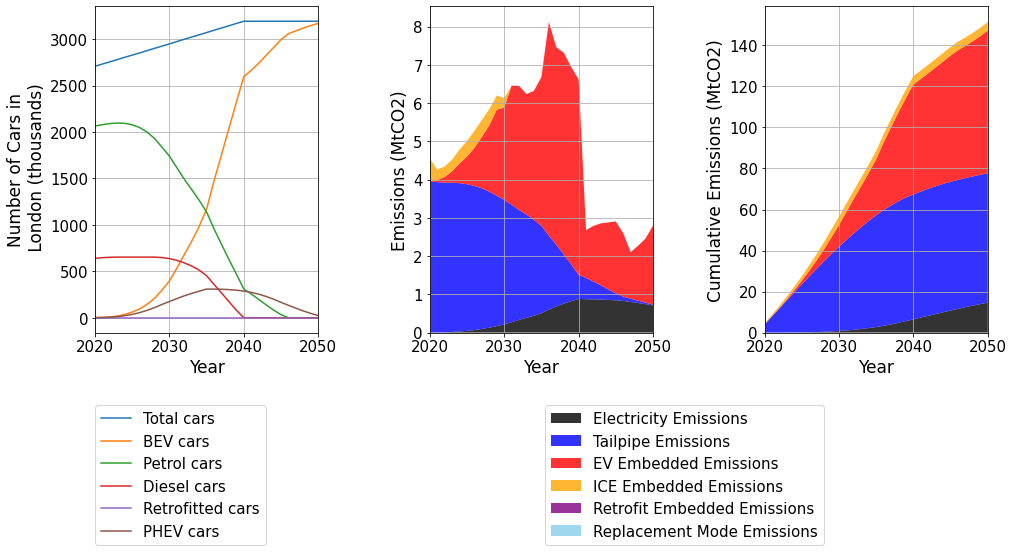

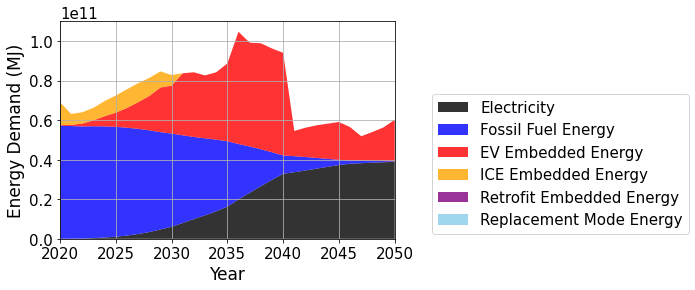

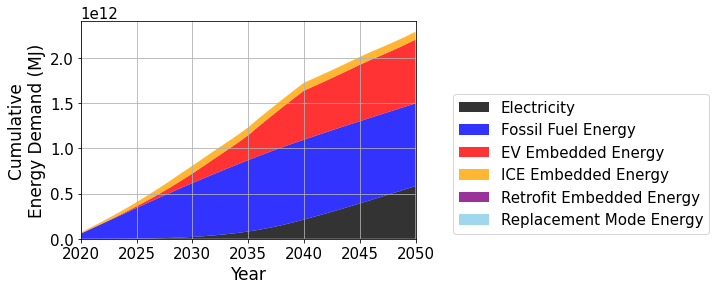

/var/folders/2m/6gbny4rx0fg8dggp6hdbhx240000gn/T/ipykernel_40524/2946535900.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  m = (y2 - y1) / (x2 - x1)
/var/folders/2m/6gbny4rx0fg8dggp6hdbhx240000gn/T/ipykernel_40524/2946535900.py:23: RuntimeWarning: divide by zero encountered in long_scalars
  m = (y2 - y1) / (x2 - x1)


Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1400 Modal shift: 20 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2020 Modal Shift Rate: 28


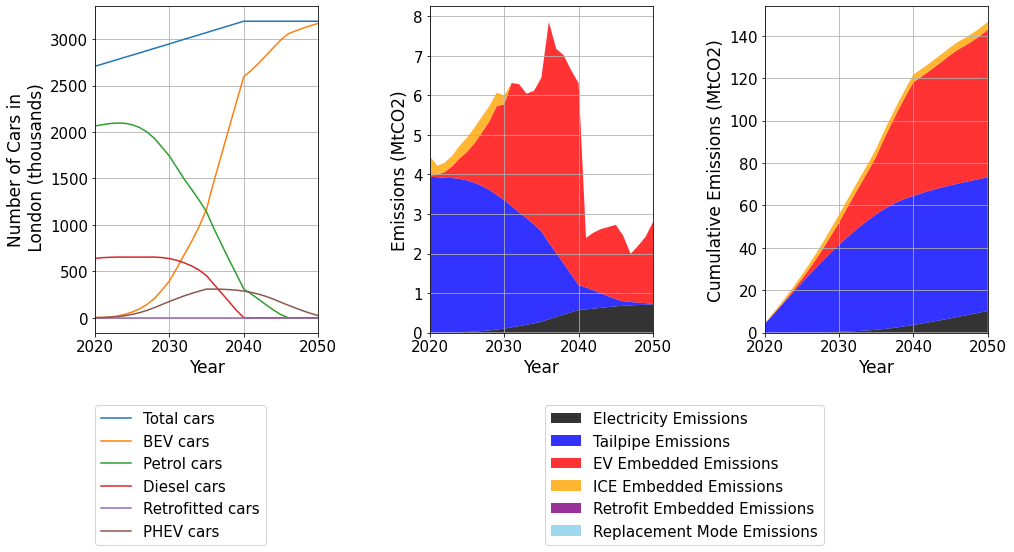

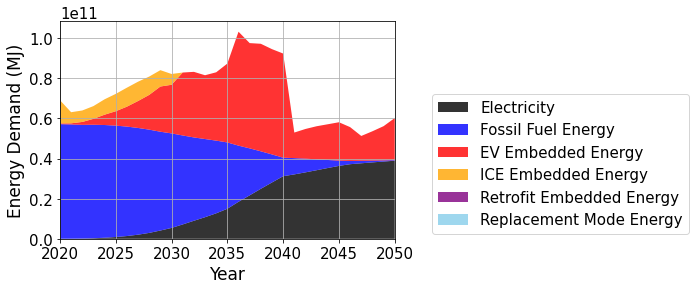

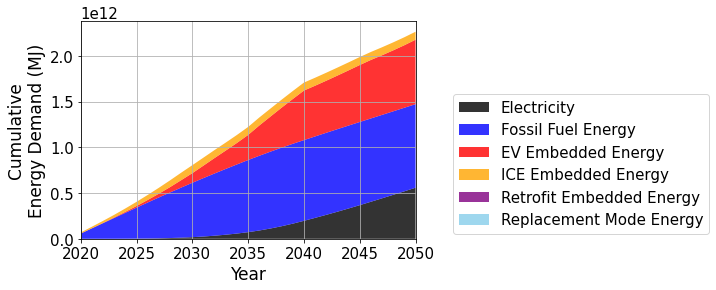

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1400 Modal shift: 20 Retro-fitting: 0 Regulated manufacture: 1 Electricity decarb: 2050 Modal Shift Rate: 28


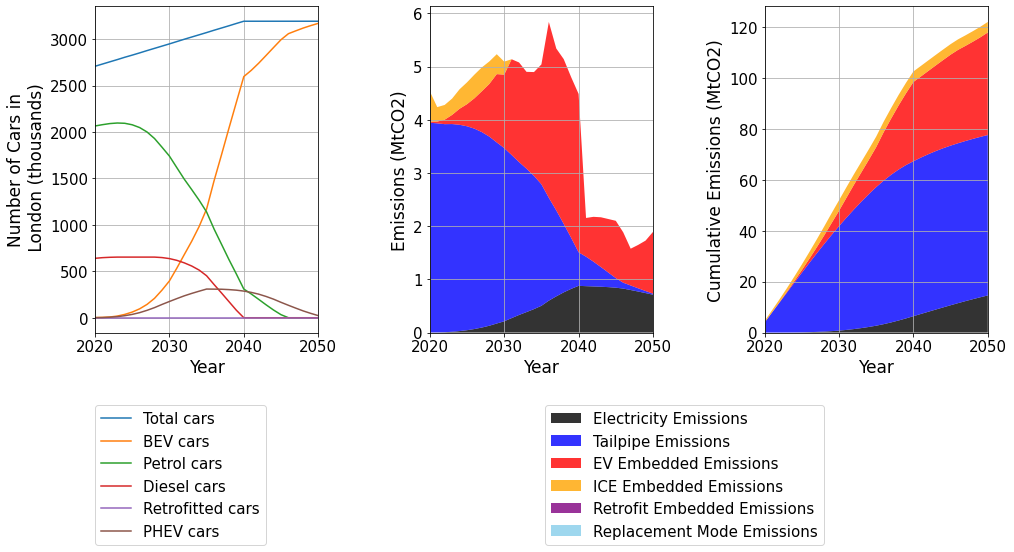

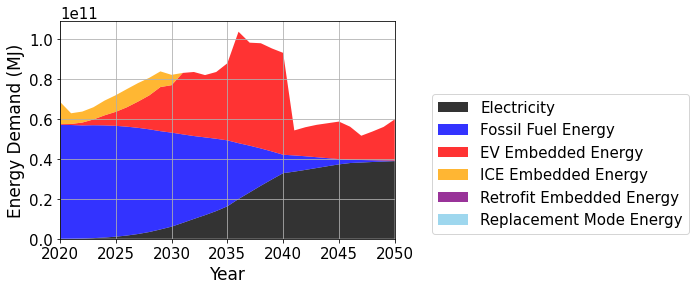

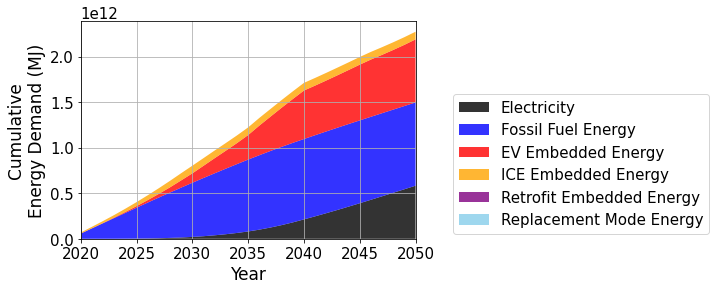

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1400 Modal shift: 20 Retro-fitting: 0.33 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 28


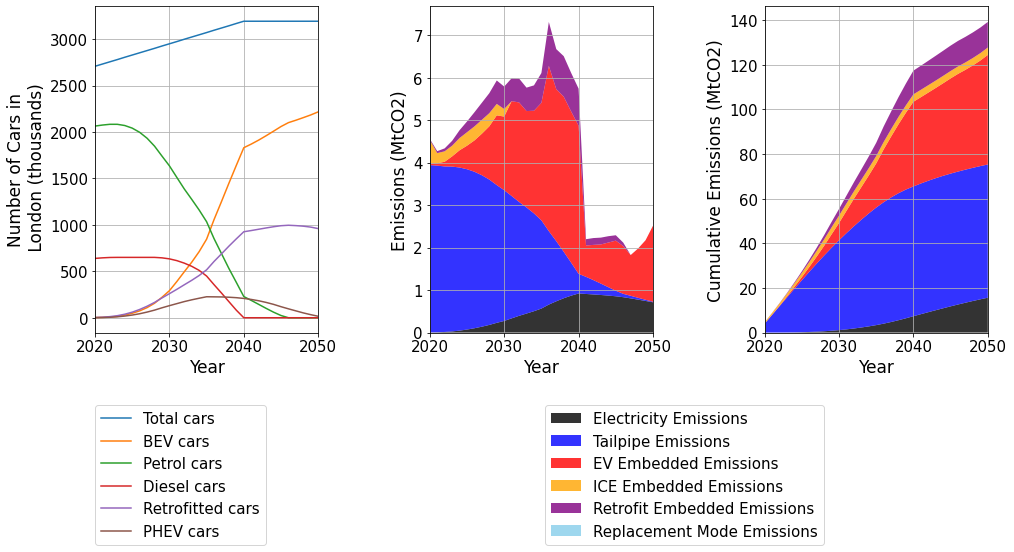

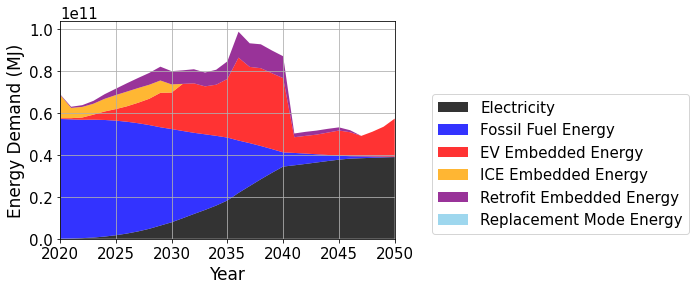

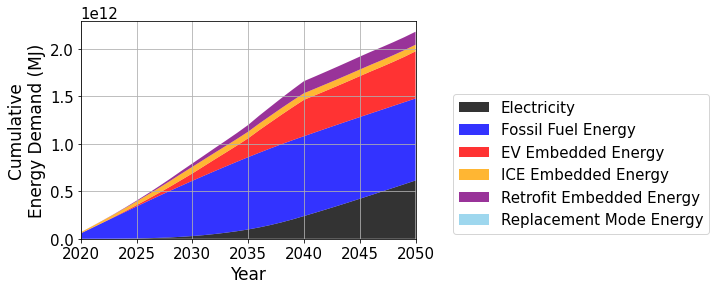

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1120 Modal shift: 20 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 28


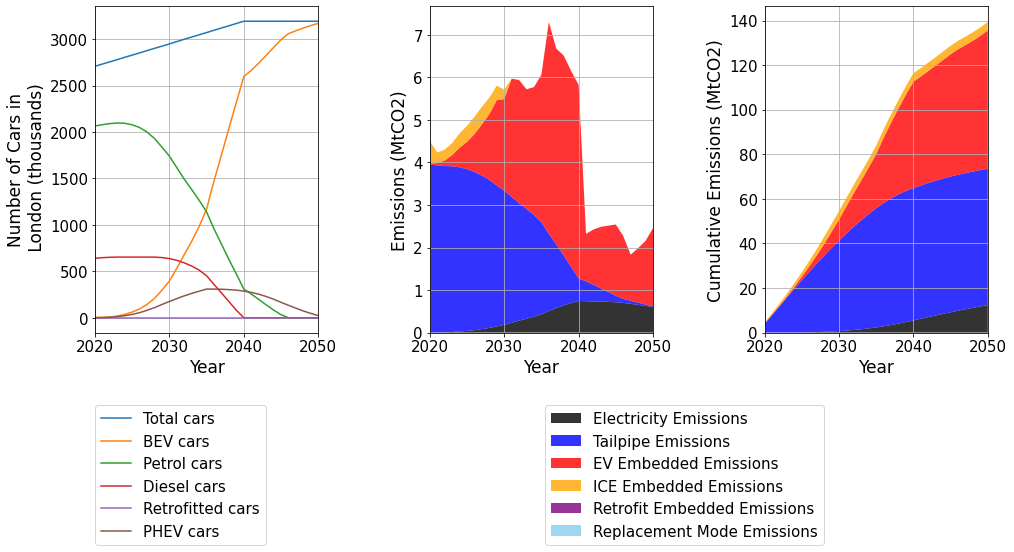

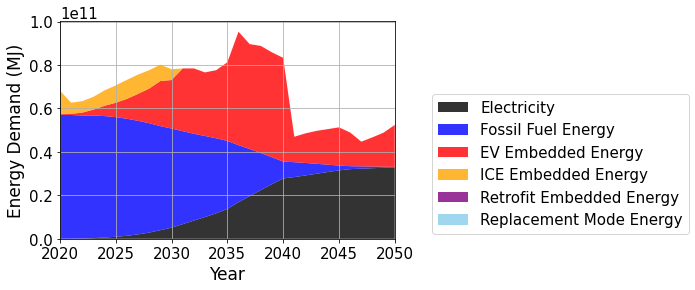

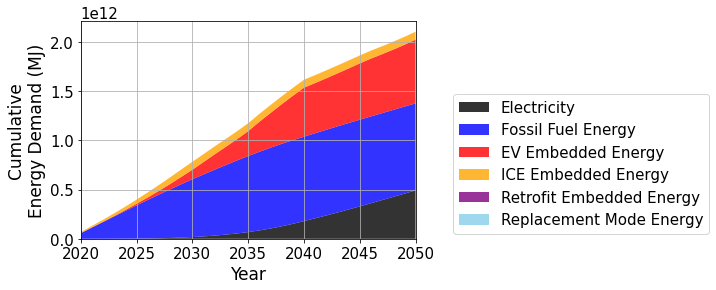

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 840 Modal shift: 20 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 28


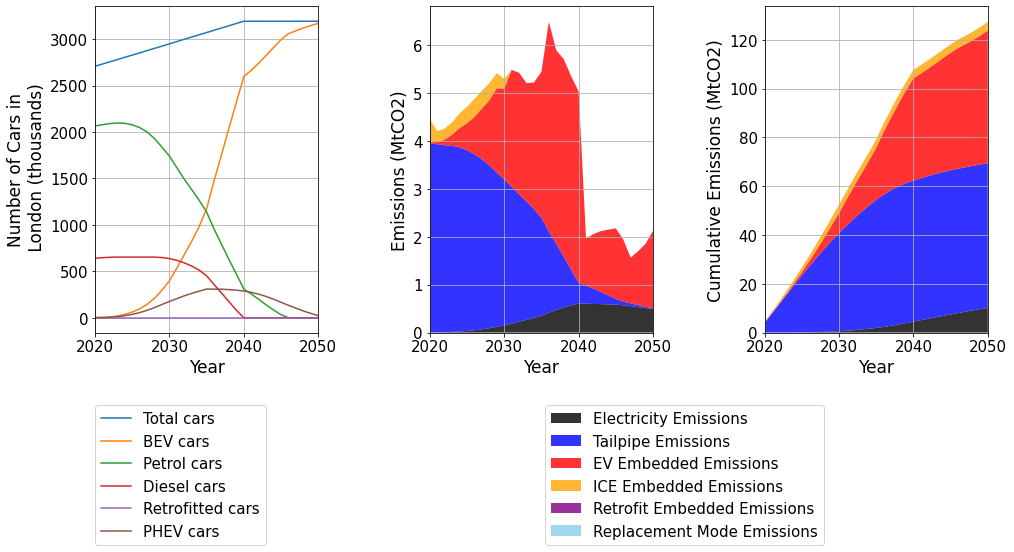

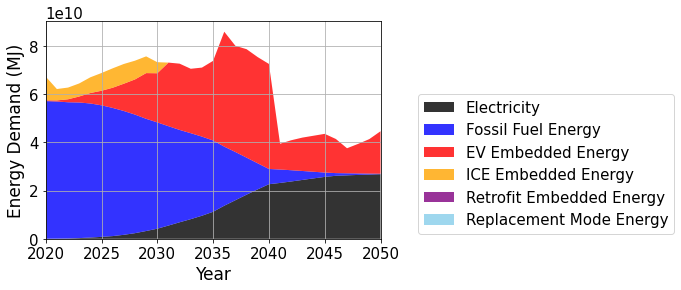

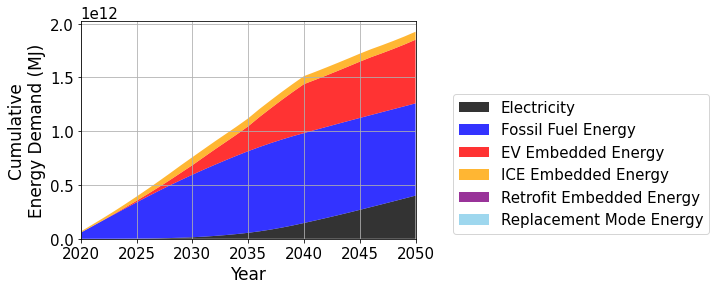

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1400 Modal shift: -42.99 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 5


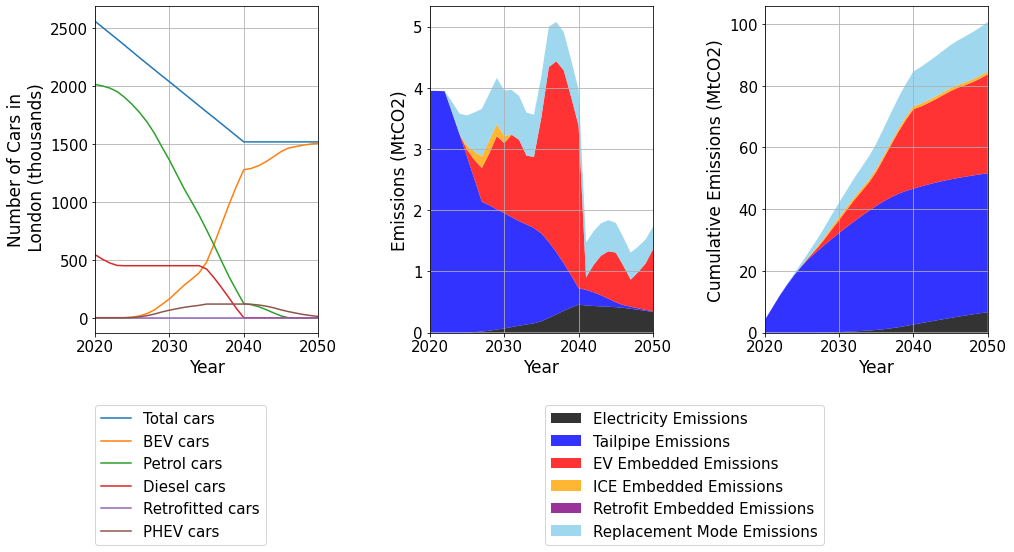

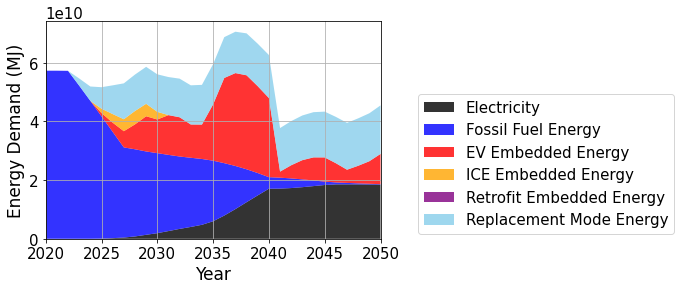

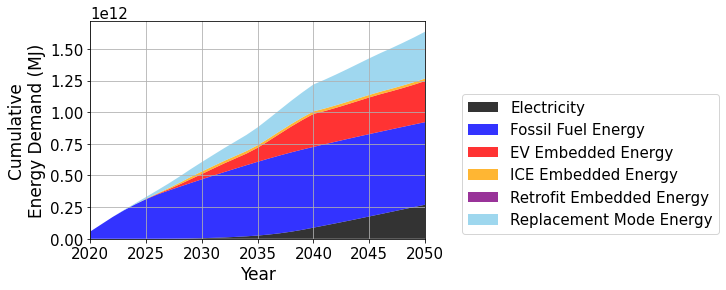

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1400 Modal shift: -66 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 5


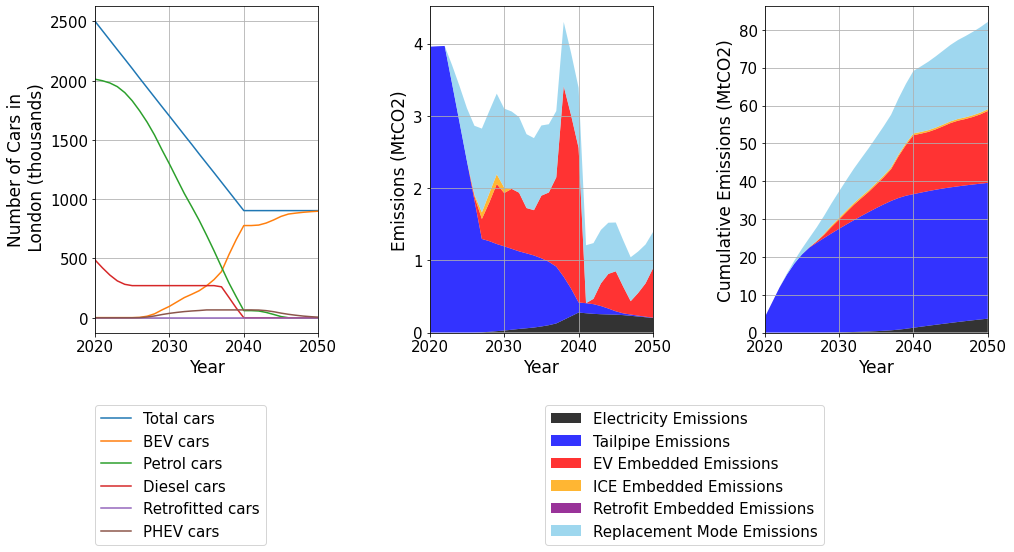

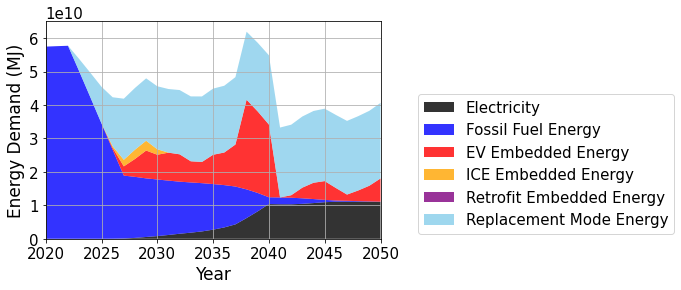

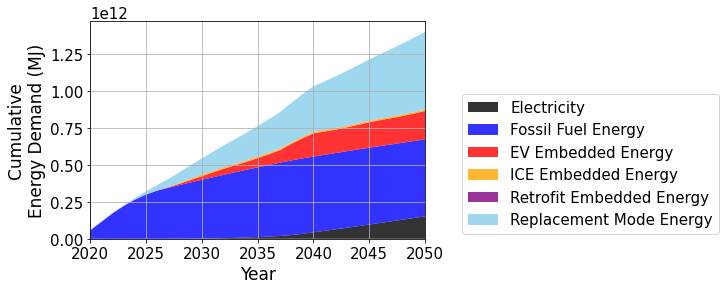

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2035 Scrap Age: 15 Light-weighting: 1400 Modal shift: -81 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 5


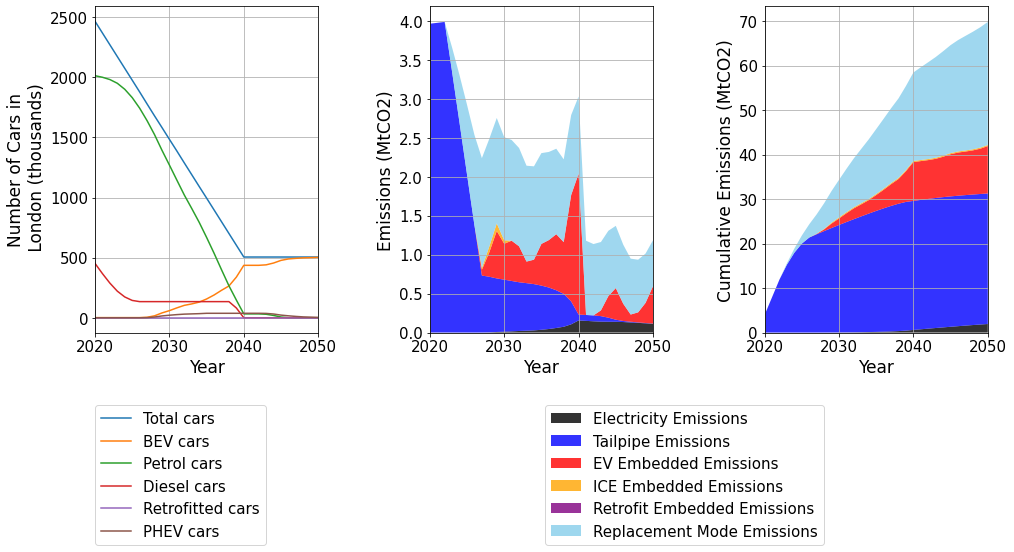

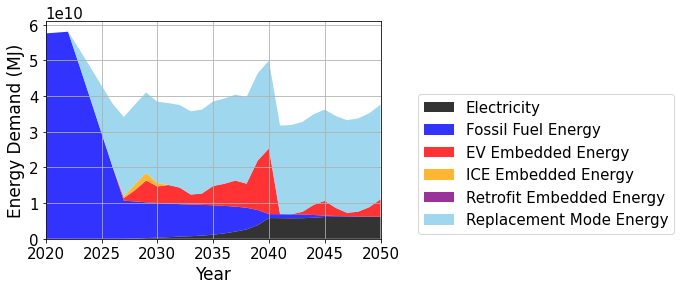

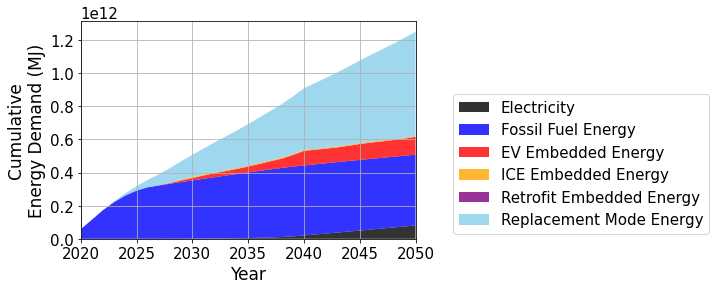

Policies: Phase-Out: 2025 Hybrid Phase-Out: 2025 Scrap Age: 15 Light-weighting: 1400 Modal shift: 20 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 28


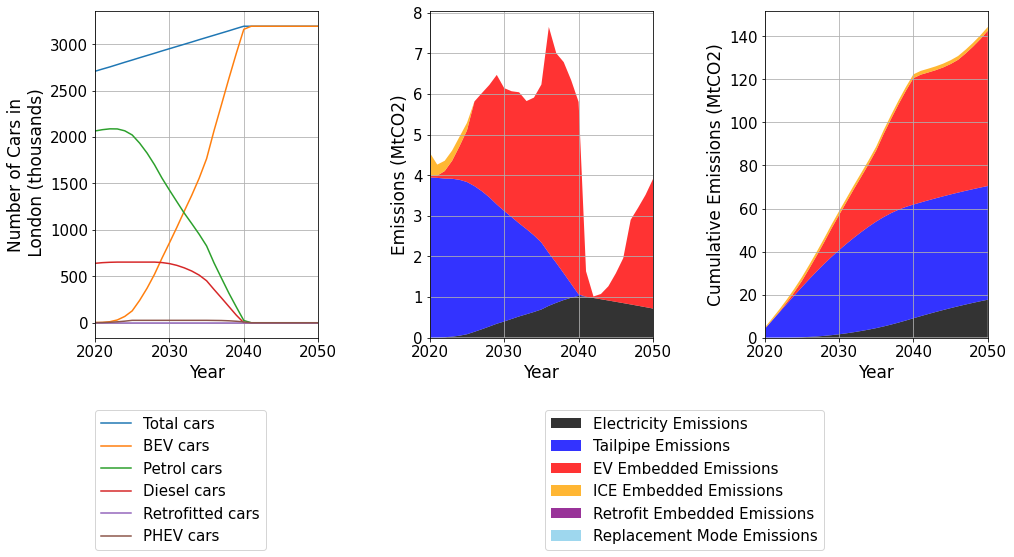

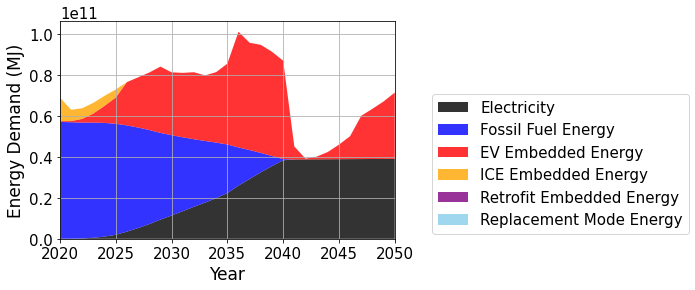

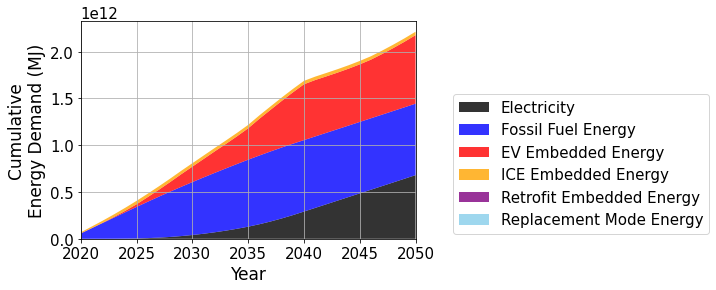

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2030 Scrap Age: 15 Light-weighting: 1400 Modal shift: 20 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 28


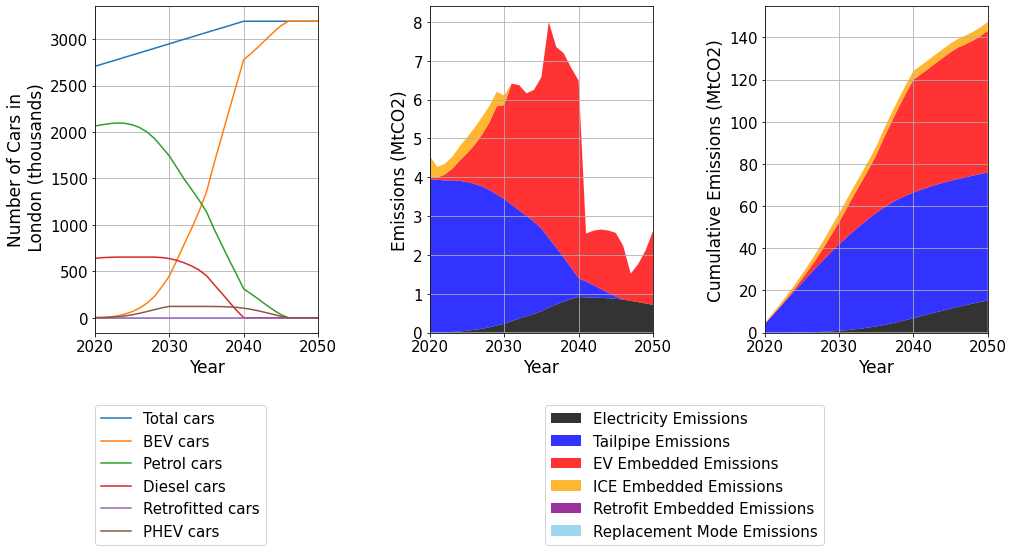

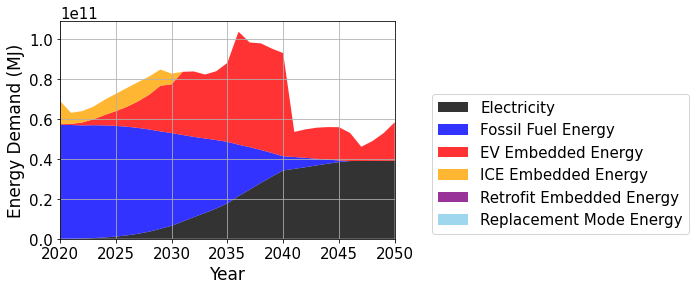

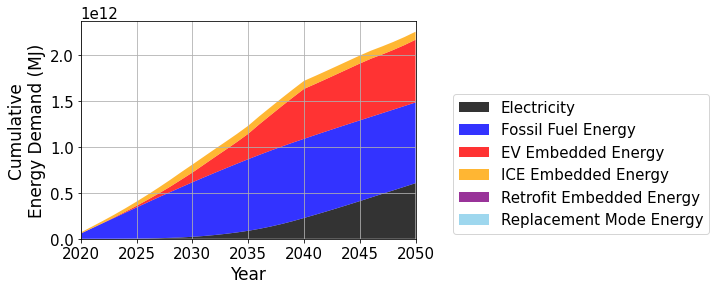

Policies: Phase-Out: 2025 Hybrid Phase-Out: 2025 Scrap Age: 10 Light-weighting: 840 Modal shift: -81 Retro-fitting: 0.33 Regulated manufacture: 1 Electricity decarb: 2020 Modal Shift Rate: 5


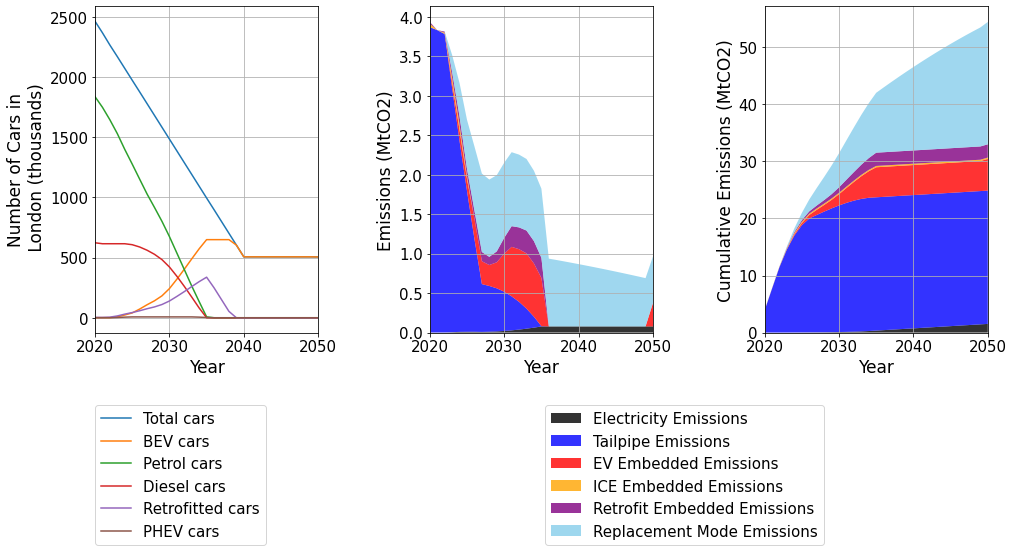

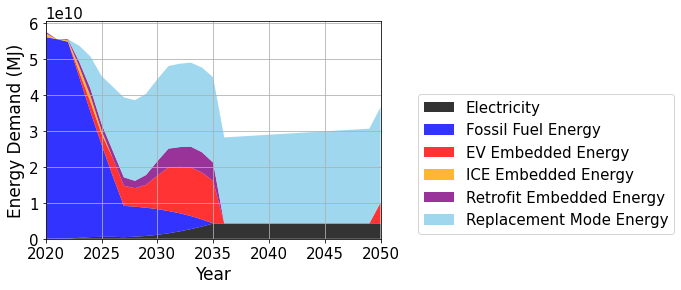

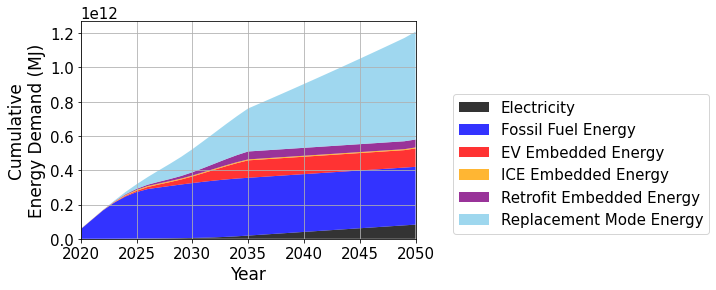

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2030 Scrap Age: 15 Light-weighting: 1400 Modal shift: -43 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 8


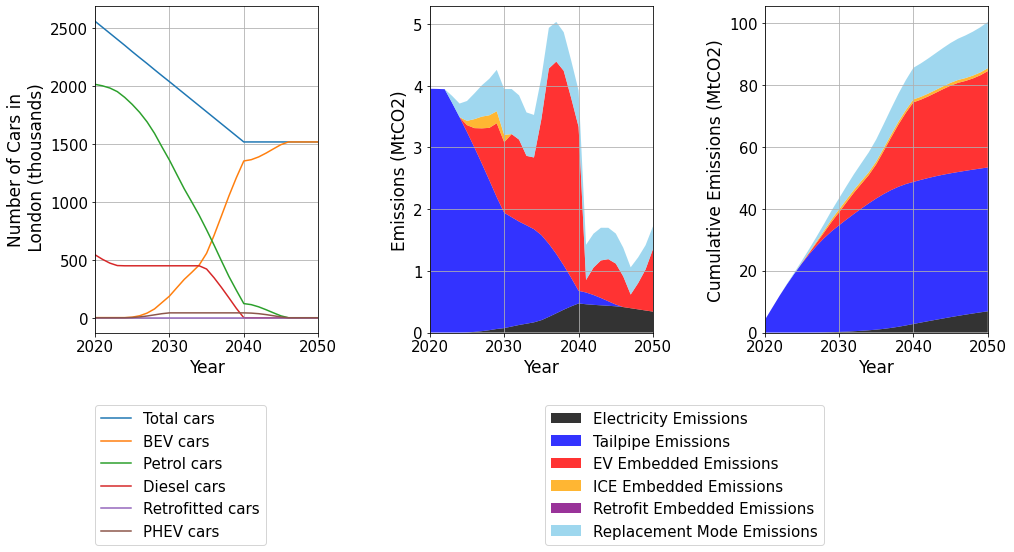

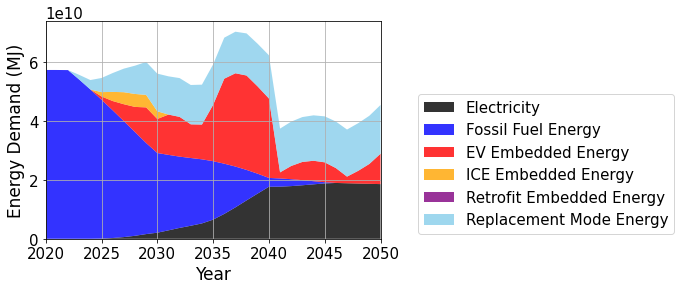

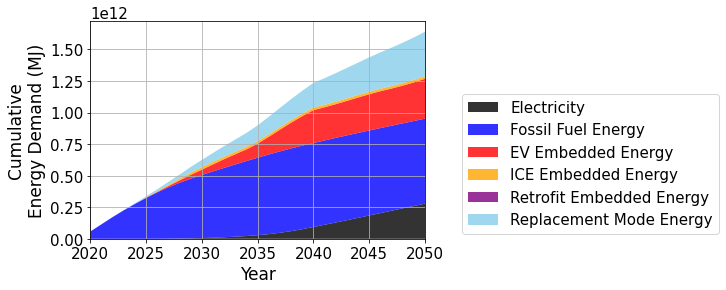

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2030 Scrap Age: 15 Light-weighting: 1400 Modal shift: -12 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 19


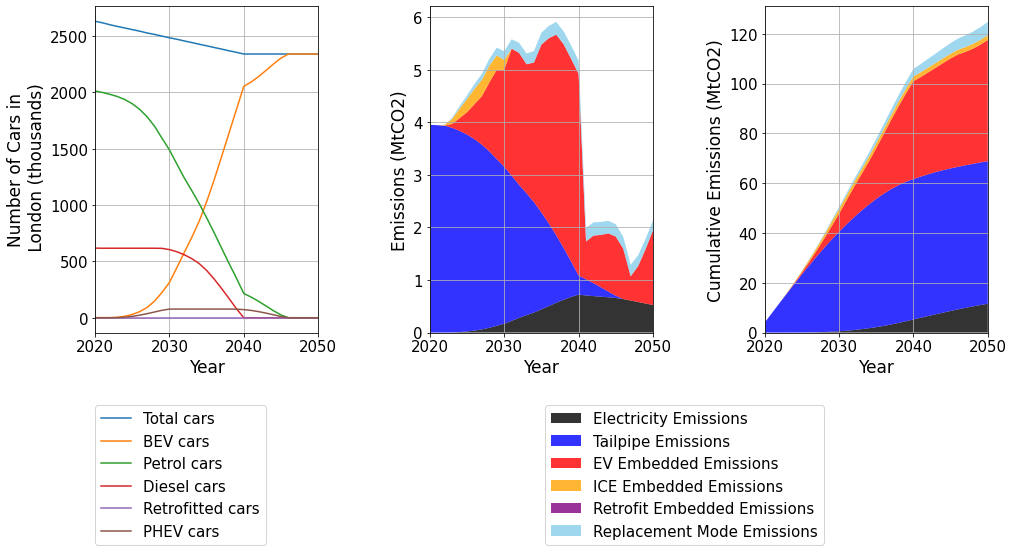

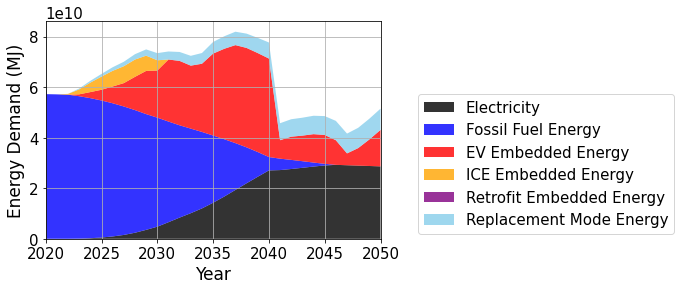

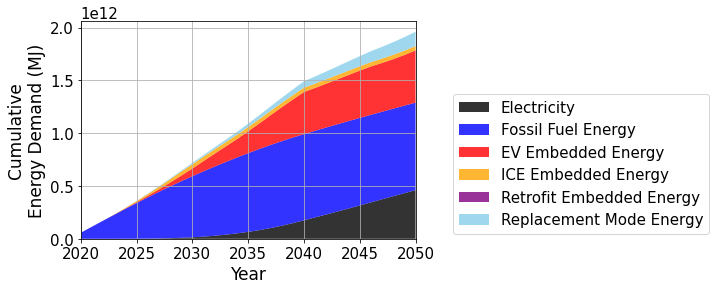

Policies: Phase-Out: 2030 Hybrid Phase-Out: 2030 Scrap Age: 15 Light-weighting: 1400 Modal shift: -27 Retro-fitting: 0 Regulated manufacture: 0 Electricity decarb: 2050 Modal Shift Rate: 8


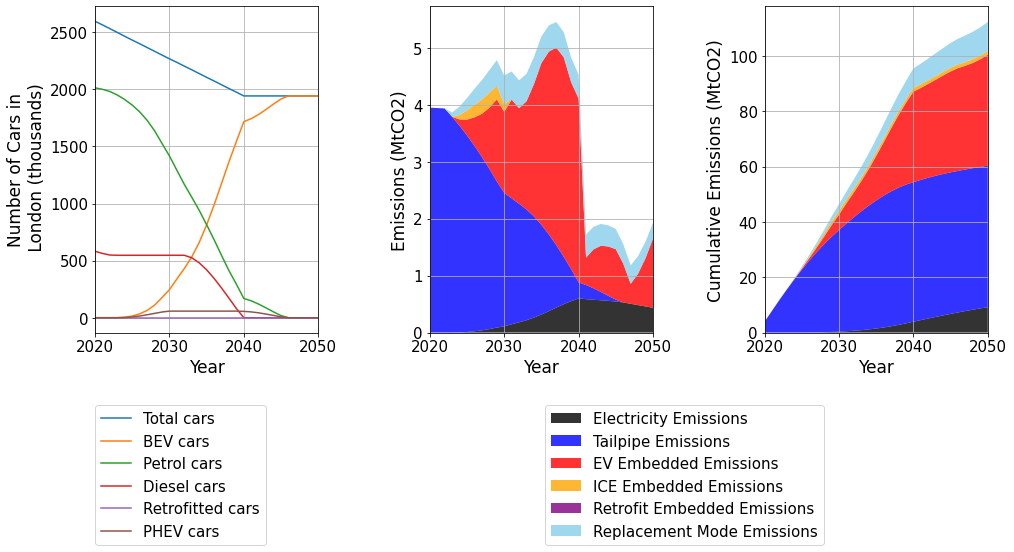

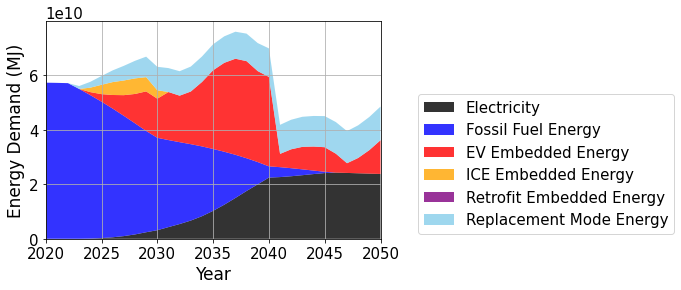

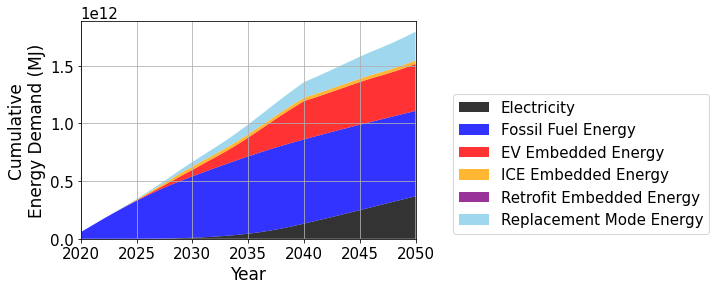

Policies: Phase-Out: 2025 Hybrid Phase-Out: 2025 Scrap Age: 10 Light-weighting: 840 Modal shift: -76 Retro-fitting: 0.2 Regulated manufacture: 1 Electricity decarb: 2020 Modal Shift Rate: 3


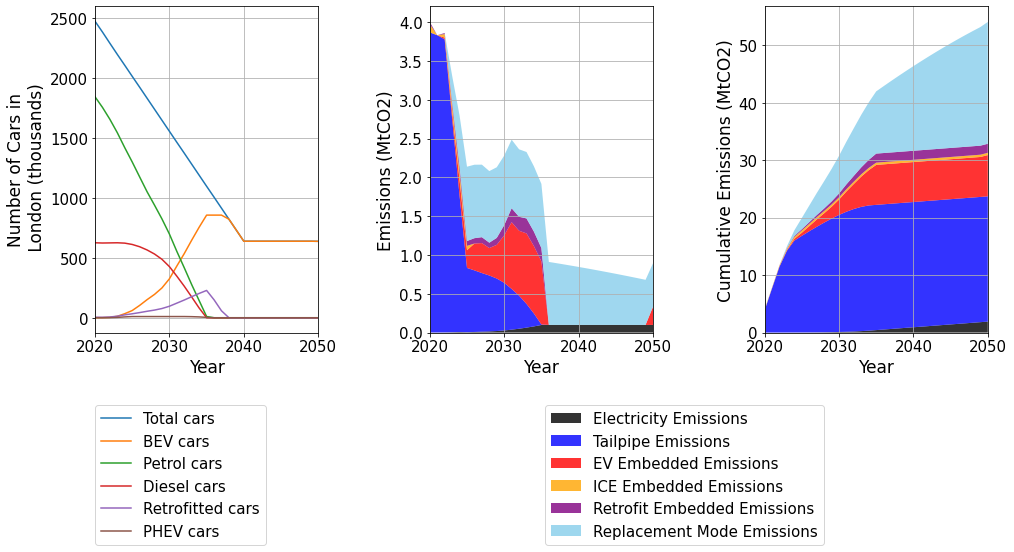

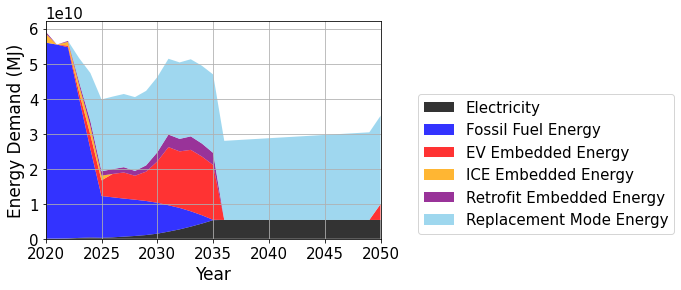

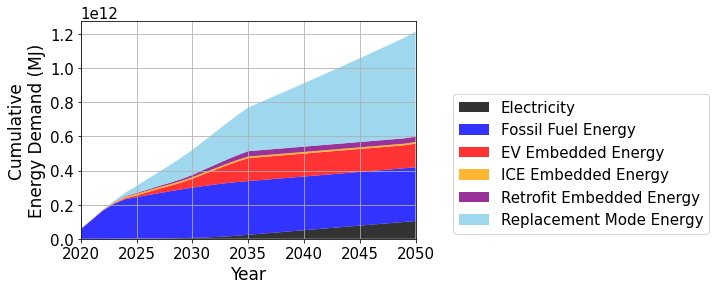

Policies: Phase-Out: 2025 Hybrid Phase-Out: 2025 Scrap Age: 10 Light-weighting: 840 Modal shift: -88 Retro-fitting: 0.2 Regulated manufacture: 1 Electricity decarb: 2020 Modal Shift Rate: 5


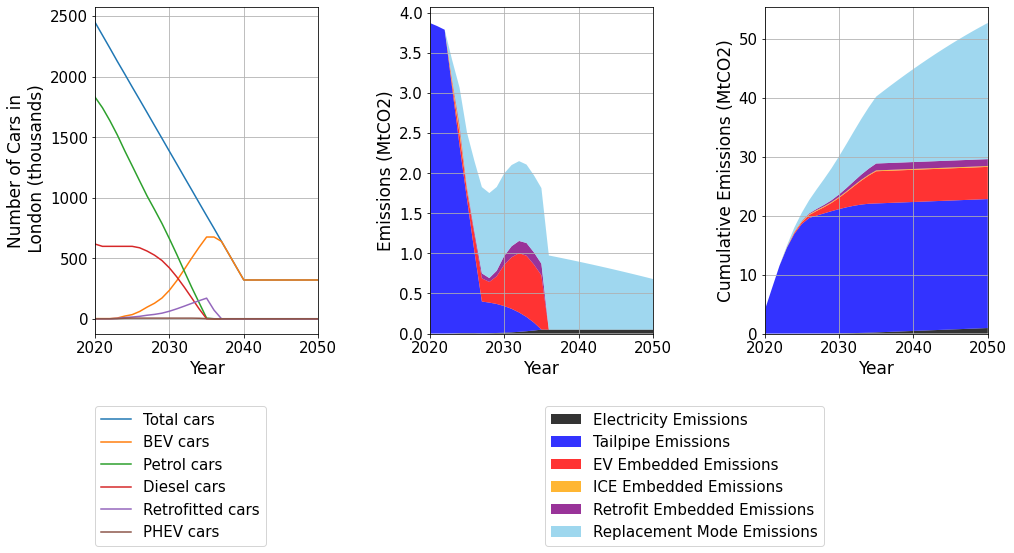

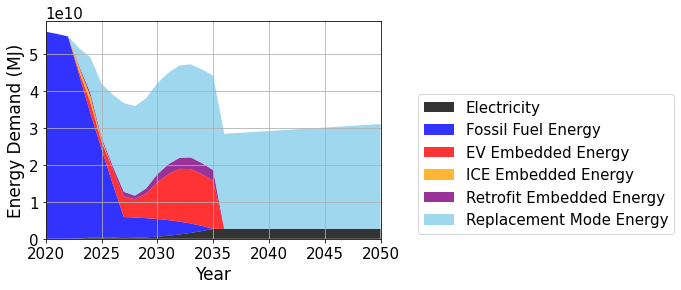

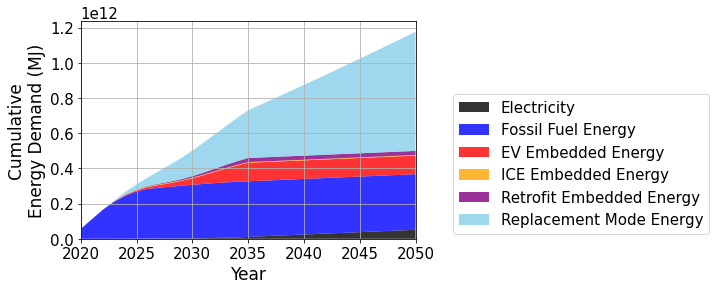

In [6]:
base=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0,manufacture=0,elec=2050,rate=28)
base_ren=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0,manufacture=0,elec=2020,rate=28)
base_eu=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0,manufacture=1,elec=2050,rate=28)
third_rf=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0.33,manufacture=0,elec=2050,rate=28)
lw_20=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1120,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0,manufacture=0,elec=2050,rate=28)
lw_40=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=840,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0,manufacture=0,elec=2050,rate=28)
d4343=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=-42.99,miles_driven_projection=-42.99,retrofit_percentage=0,manufacture=0,elec=2050,rate=5)
d6666=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=-66,miles_driven_projection=-66,retrofit_percentage=0,manufacture=0,elec=2050,rate=5)
d8181=Run_Model(phase_out_date=2030,phase_out_hybrid=2035,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=-81,miles_driven_projection=-81,retrofit_percentage=0,manufacture=0,elec=2050,rate=5)
p2525=Run_Model(phase_out_date=2025,phase_out_hybrid=2025,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0,manufacture=0,elec=2050,rate=28)
p3030=Run_Model(phase_out_date=2030,phase_out_hybrid=2030,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=20,miles_driven_projection=20,retrofit_percentage=0,manufacture=0,elec=2050,rate=28)
opt=Run_Model(phase_out_date=2025,phase_out_hybrid=2025,scrap_age_pre2020=15,scrap_age_post2020=10,mass=840,\
               fleet_size_projection=-81,miles_driven_projection=-81,retrofit_percentage=0.33,manufacture=1,elec=2020,rate=5)
mts=Run_Model(phase_out_date=2030,phase_out_hybrid=2030,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=-43,miles_driven_projection=-43,retrofit_percentage=0,manufacture=0,elec=2050,rate=8)
mts1=Run_Model(phase_out_date=2030,phase_out_hybrid=2030,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=-12,miles_driven_projection=-12,retrofit_percentage=0,manufacture=0,elec=2050,rate=19)
mts2=Run_Model(phase_out_date=2030,phase_out_hybrid=2030,scrap_age_pre2020=20,scrap_age_post2020=15,mass=1400,\
               fleet_size_projection=-27,miles_driven_projection=-27,retrofit_percentage=0,manufacture=0,elec=2050,rate=8)
extreme1=Run_Model(phase_out_date=2025,phase_out_hybrid=2025,scrap_age_pre2020=15,scrap_age_post2020=10,mass=840,\
               fleet_size_projection=-76,miles_driven_projection=-76,retrofit_percentage=0.2,manufacture=1,elec=2020,rate=3)
extreme2=Run_Model(phase_out_date=2025,phase_out_hybrid=2025,scrap_age_pre2020=15,scrap_age_post2020=10,mass=840,\
               fleet_size_projection=-88,miles_driven_projection=-88,retrofit_percentage=0.2,manufacture=1,elec=2020,rate=5)

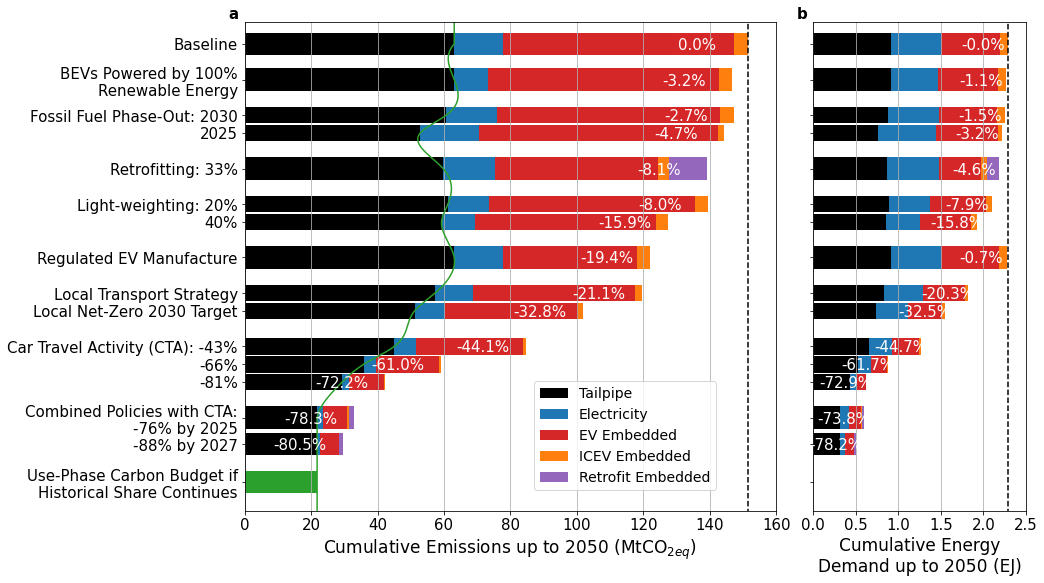

In [7]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

x=["Baseline","BEVs Powered by 100%\nRenewable Energy","Fossil Fuel Phase-Out: 2030", "2025","Retrofitting: 33%",
   "Light-weighting: 20%","40%", "Regulated EV Manufacture",
   "Local Transport Strategy","Local Net-Zero 2030 Target","Car Travel Activity (CTA): -43%","-66%","-81%",
   "Combined Policies with CTA:\n-76% by 2025","-88% by 2027","Use-Phase Carbon Budget if\nHistorical Share Continues"]

electric=[base[6][-1],base_ren[6][-1],p3030[6][-1],p2525[6][-1],third_rf[6][-1],lw_20[6][-1],lw_40[6][-1],base_eu[6][-1],mts1[6][-1],mts2[6][-1],d4343[6][-1],d6666[6][-1],d8181[6][-1],extreme1[6][-1],extreme2[6][-1],0]
elec=((np.array(electric)))

tailpipe=[base[7][-1],base_ren[7][-1],p3030[7][-1],p2525[7][-1],third_rf[7][-1],lw_20[7][-1],lw_40[7][-1],base_eu[7][-1],mts1[7][-1],mts2[7][-1],d4343[7][-1],d6666[7][-1],d8181[7][-1],extreme1[7][-1],extreme2[7][-1],0]
tail=((np.array(tailpipe)))

ev_prod=[base[8][-1],base_ren[8][-1],p3030[8][-1],p2525[8][-1],third_rf[8][-1],lw_20[8][-1],lw_40[8][-1],base_eu[8][-1],mts1[8][-1],mts2[8][-1],d4343[8][-1],d6666[8][-1],d8181[8][-1],extreme1[8][-1],extreme2[8][-1],0]
ev=((np.array(ev_prod)))

ice_prod=[base[9][-1],base_ren[9][-1],p3030[9][-1],p2525[9][-1],third_rf[9][-1],lw_20[9][-1],lw_40[9][-1],base_eu[9][-1],mts1[9][-1],mts2[9][-1],d4343[9][-1],d6666[9][-1],d8181[9][-1],extreme1[9][-1],extreme2[9][-1],0]
ice=((np.array(ice_prod)))

converted=[base[10][-1],base_ren[10][-1],p3030[10][-1],p2525[10][-1],third_rf[10][-1],lw_20[10][-1],lw_40[10][-1],base_eu[10][-1],mts1[10][-1],mts2[10][-1],d4343[10][-1],d6666[10][-1],d8181[10][-1],extreme1[10][-1],extreme2[10][-1],0]
conv=((np.array(converted)))

carbon_budg=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21.7]
cb=((np.array(carbon_budg)))

electric1=[base[18][-1],base_ren[18][-1],p3030[18][-1],p2525[18][-1],third_rf[18][-1],lw_20[18][-1],lw_40[18][-1],base_eu[18][-1],mts1[18][-1],mts2[18][-1],d4343[18][-1],d6666[18][-1],d8181[18][-1],extreme1[18][-1],extreme2[18][-1],0]
elec1=((np.array(electric1))/10**12)

tailpipe1=[base[19][-1],base_ren[19][-1],p3030[19][-1],p2525[19][-1],third_rf[19][-1],lw_20[19][-1],lw_40[19][-1],base_eu[19][-1],mts1[19][-1],mts2[19][-1],d4343[19][-1],d6666[19][-1],d8181[19][-1],extreme1[19][-1],extreme2[19][-1],0]
tail1=((np.array(tailpipe1))/10**12)

ev_prod1=[base[20][-1],base_ren[20][-1],p3030[20][-1],p2525[20][-1],third_rf[20][-1],lw_20[20][-1],lw_40[20][-1],base_eu[20][-1],mts1[20][-1],mts2[20][-1],d4343[20][-1],d6666[20][-1],d8181[20][-1],extreme1[20][-1],extreme2[20][-1],0]
ev1=((np.array(ev_prod1))/10**12)

ice_prod1=[base[21][-1],base_ren[21][-1],p3030[21][-1],p2525[21][-1],third_rf[21][-1],lw_20[21][-1],lw_40[21][-1],base_eu[21][-1],mts1[21][-1],mts2[21][-1],d4343[21][-1],d6666[21][-1],d8181[21][-1],extreme1[21][-1],extreme2[21][-1],0]
ice1=((np.array(ice_prod1))/10**12)

converted1=[base[22][-1],base_ren[22][-1],p3030[22][-1],p2525[22][-1],third_rf[22][-1],lw_20[22][-1],lw_40[22][-1],base_eu[22][-1],mts1[22][-1],mts2[22][-1],d4343[22][-1],d6666[22][-1],d8181[22][-1],extreme1[22][-1],extreme2[22][-1],0]
conv1=((np.array(converted1))/10**12)


per=((elec+tail+ev+ice+conv-(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]))/(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]))*100
per1=((elec1+tail1+ev1+ice1+conv1-(base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12)/((base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12))*100


fig, axs = plt.subplots(1,2,figsize=(14,9),sharey=True,sharex=False, gridspec_kw={'width_ratios': [5, 2]})

# horizontal space between axes
fig.subplots_adjust(wspace=0.1)

pos = [0,1.6,3.2,4,5.6,7.2,8,9.6,11.2,12,13.6,14.4,15.2,16.8,18,19.7]
width = [1,1,0.75,0.75,1,0.75,0.75,1,0.75,0.75,0.75,0.75,0.75,1,1,1]
error=np.random.rand(8)

axs[0].grid(axis='x')
axs[0].barh(pos,tail,width,color=['black'], align='center',label='Tailpipe')
axs[0].barh(pos,elec,width,tail,color=['tab:blue'], align='center',label='Electricity')
axs[0].barh(pos,ev,width,elec+tail,color=['tab:red'], align='center',label='EV Embedded',alpha=1)
axs[0].barh(pos,ice,width,elec+tail+ev,color=['tab:orange'], align='center',label='ICEV Embedded')
axs[0].barh(pos,conv,width,elec+tail+ev+ice,color=['tab:purple'], align='center',label='Retrofit Embedded')
axs[0].barh(pos,cb,width,elec+tail+ev+ice+conv,color=['tab:green'], align='center')

axs[0].legend(bbox_to_anchor=(0.9,0.28), prop={'size': 14})
axs[0].set_xlim(0,160)
axs[0].set_ylim(-1,21)

axs[0].set_xlabel('Cumulative Emissions up to 2050 (MtCO$_{2eq}$)')
axs[0].invert_yaxis()
axs[0].set_yticks(pos)
axs[0].set_yticklabels(x)
axs[0].invert_yaxis()
axs[0].plot([(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]), (base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1])], [-2,24], "k--")
#axs[0].plot([21.7,21.7], [-2,24], "k--",color='black')
axs[0].text(-0.03, 1, 'a', transform=axs[0].transAxes,fontsize='medium', va='bottom',weight="bold")

from scipy.interpolate import make_interp_spline

x_new = np.linspace(0, 16.8, 300)
a_BSpline = make_interp_spline(pos[0:16],np.array(tail)[0:16])
y_new = a_BSpline(x_new)



axs[0].plot([63.08470628110841]+list(y_new)+[21.80],[-1]+list(x_new)+[21.7],color='tab:green', alpha=1)

axs[0].set_yticks(pos)
axs[0].set_yticklabels(x)


axs[1].barh(pos,tail1,width,color=['black'], align='center',label='Tailpipe')
axs[1].barh(pos,elec1,width,tail1,color=['tab:blue'], align='center',label='Electricity')
axs[1].barh(pos,ev1,width,elec1+tail1,color=['tab:red'], align='center',label='EV Embedded')
axs[1].barh(pos,ice1,width,elec1+tail1+ev1,color=['tab:orange'], align='center',label='ICEV Embedded')
axs[1].barh(pos,conv1,width,elec1+tail1+ev1+ice1,color=['tab:purple'], align='center',label='Retrofit Embedded')
axs[1].grid(axis='x')
axs[1].set_xlabel('Cumulative Energy\nDemand up to 2050 (EJ)')
axs[1].set_yticks(pos)
axs[1].set_yticklabels(x)
axs[1].plot([(base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12, (base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12], [-2,24], "k--")
axs[1].text(-0.08, 1, 'b', transform=axs[1].transAxes,fontsize='medium', va='bottom',weight="bold")
axs[1].set_xticks(np.arange(0,3,0.5))

"""
for i, v in enumerate(elec+tail+ev+ice+conv):
    if i<15:
        axs[0].text(v-21,pos[i]+0.25, '{:.1f}%'.format(per[i]))
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1
"""
for i, v in enumerate(elec+tail+ev+ice+conv):
    if i<15:
        axs[0].text(v-21,pos[i]+0.25, '{:.1f}%'.format(per[i]),color='white')
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1

for i, v in enumerate(elec1+tail1+ev1+ice1+conv1):
    if i<15:
        axs[1].text(v-0.55,pos[i]+0.25, '{:.1f}%'.format(per1[i]),color='white')
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1 
        
plt.gca().invert_yaxis()
plt.savefig('Fig1.pdf', bbox_inches="tight")
plt.savefig('Fig1.png', bbox_inches="tight")
plt.show()

/var/folders/2m/6gbny4rx0fg8dggp6hdbhx240000gn/T/ipykernel_43081/1781295379.py:83: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([63.8,63.8], [-2,25], "k--",color='black')


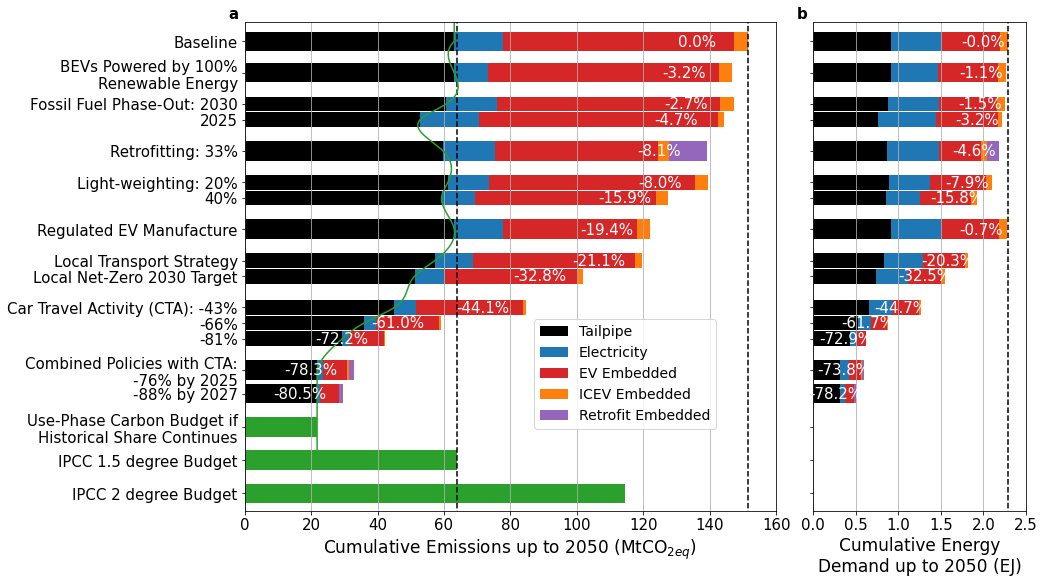

In [18]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

x=["Baseline","BEVs Powered by 100%\nRenewable Energy","Fossil Fuel Phase-Out: 2030", "2025","Retrofitting: 33%",
   "Light-weighting: 20%","40%", "Regulated EV Manufacture",
   "Local Transport Strategy","Local Net-Zero 2030 Target","Car Travel Activity (CTA): -43%","-66%","-81%",
   "Combined Policies with CTA:\n-76% by 2025","-88% by 2027","Use-Phase Carbon Budget if\nHistorical Share Continues","IPCC 1.5 degree Budget","IPCC 2 degree Budget"]

electric=[base[6][-1],base_ren[6][-1],p3030[6][-1],p2525[6][-1],third_rf[6][-1],lw_20[6][-1],lw_40[6][-1],base_eu[6][-1],mts1[6][-1],mts2[6][-1],d4343[6][-1],d6666[6][-1],d8181[6][-1],extreme1[6][-1],extreme2[6][-1],0,0,0]
elec=((np.array(electric)))

tailpipe=[base[7][-1],base_ren[7][-1],p3030[7][-1],p2525[7][-1],third_rf[7][-1],lw_20[7][-1],lw_40[7][-1],base_eu[7][-1],mts1[7][-1],mts2[7][-1],d4343[7][-1],d6666[7][-1],d8181[7][-1],extreme1[7][-1],extreme2[7][-1],0,0,0]
tail=((np.array(tailpipe)))

ev_prod=[base[8][-1],base_ren[8][-1],p3030[8][-1],p2525[8][-1],third_rf[8][-1],lw_20[8][-1],lw_40[8][-1],base_eu[8][-1],mts1[8][-1],mts2[8][-1],d4343[8][-1],d6666[8][-1],d8181[8][-1],extreme1[8][-1],extreme2[8][-1],0,0,0]
ev=((np.array(ev_prod)))

ice_prod=[base[9][-1],base_ren[9][-1],p3030[9][-1],p2525[9][-1],third_rf[9][-1],lw_20[9][-1],lw_40[9][-1],base_eu[9][-1],mts1[9][-1],mts2[9][-1],d4343[9][-1],d6666[9][-1],d8181[9][-1],extreme1[9][-1],extreme2[9][-1],0,0,0]
ice=((np.array(ice_prod)))

converted=[base[10][-1],base_ren[10][-1],p3030[10][-1],p2525[10][-1],third_rf[10][-1],lw_20[10][-1],lw_40[10][-1],base_eu[10][-1],mts1[10][-1],mts2[10][-1],d4343[10][-1],d6666[10][-1],d8181[10][-1],extreme1[10][-1],extreme2[10][-1],0,0,0]
conv=((np.array(converted)))

carbon_budg=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21.7,0,0]
cb=((np.array(carbon_budg)))

carbon_budg1=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.8,0]
cb1=((np.array(carbon_budg1)))

carbon_budg2=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114.4]
cb2=((np.array(carbon_budg2)))

electric1=[base[18][-1],base_ren[18][-1],p3030[18][-1],p2525[18][-1],third_rf[18][-1],lw_20[18][-1],lw_40[18][-1],base_eu[18][-1],mts1[18][-1],mts2[18][-1],d4343[18][-1],d6666[18][-1],d8181[18][-1],extreme1[18][-1],extreme2[18][-1],0,0,0]
elec1=((np.array(electric1))/10**12)

tailpipe1=[base[19][-1],base_ren[19][-1],p3030[19][-1],p2525[19][-1],third_rf[19][-1],lw_20[19][-1],lw_40[19][-1],base_eu[19][-1],mts1[19][-1],mts2[19][-1],d4343[19][-1],d6666[19][-1],d8181[19][-1],extreme1[19][-1],extreme2[19][-1],0,0,0]
tail1=((np.array(tailpipe1))/10**12)

ev_prod1=[base[20][-1],base_ren[20][-1],p3030[20][-1],p2525[20][-1],third_rf[20][-1],lw_20[20][-1],lw_40[20][-1],base_eu[20][-1],mts1[20][-1],mts2[20][-1],d4343[20][-1],d6666[20][-1],d8181[20][-1],extreme1[20][-1],extreme2[20][-1],0,0,0]
ev1=((np.array(ev_prod1))/10**12)

ice_prod1=[base[21][-1],base_ren[21][-1],p3030[21][-1],p2525[21][-1],third_rf[21][-1],lw_20[21][-1],lw_40[21][-1],base_eu[21][-1],mts1[21][-1],mts2[21][-1],d4343[21][-1],d6666[21][-1],d8181[21][-1],extreme1[21][-1],extreme2[21][-1],0,0,0]
ice1=((np.array(ice_prod1))/10**12)

converted1=[base[22][-1],base_ren[22][-1],p3030[22][-1],p2525[22][-1],third_rf[22][-1],lw_20[22][-1],lw_40[22][-1],base_eu[22][-1],mts1[22][-1],mts2[22][-1],d4343[22][-1],d6666[22][-1],d8181[22][-1],extreme1[22][-1],extreme2[22][-1],0,0,0]
conv1=((np.array(converted1))/10**12)


per=((elec+tail+ev+ice+conv-(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]))/(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]))*100
per1=((elec1+tail1+ev1+ice1+conv1-(base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12)/((base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12))*100


fig, axs = plt.subplots(1,2,figsize=(14,9),sharey=True,sharex=False, gridspec_kw={'width_ratios': [5, 2]})

# horizontal space between axes
fig.subplots_adjust(wspace=0.1)

pos = [0,1.6,3.2,4,5.6,7.2,8,9.6,11.2,12,13.6,14.4,15.2,16.8,18,19.7,21.4,23.1]
width = [1,1,0.75,0.75,1,0.75,0.75,1,0.75,0.75,0.75,0.75,0.75,1,1,1,1,1]
error=np.random.rand(8)

axs[0].grid(axis='x')
axs[0].barh(pos,tail,width,color=['black'], align='center',label='Tailpipe')
axs[0].barh(pos,elec,width,tail,color=['tab:blue'], align='center',label='Electricity')
axs[0].barh(pos,ev,width,elec+tail,color=['tab:red'], align='center',label='EV Embedded',alpha=1)
axs[0].barh(pos,ice,width,elec+tail+ev,color=['tab:orange'], align='center',label='ICEV Embedded')
axs[0].barh(pos,conv,width,elec+tail+ev+ice,color=['tab:purple'], align='center',label='Retrofit Embedded')
axs[0].barh(pos,cb,width,elec+tail+ev+ice+conv,color=['tab:green'], align='center')
axs[0].barh(pos,cb1,width,elec+tail+ev+ice+conv+cb,color=['tab:green'], align='center')
axs[0].barh(pos,cb2,width,elec+tail+ev+ice+conv+cb1,color=['tab:green'], align='center')

axs[0].legend(bbox_to_anchor=(0.9,0.28), prop={'size': 14})
axs[0].set_xlim(0,160)
axs[0].set_ylim(-1,24)

axs[0].set_xlabel('Cumulative Emissions up to 2050 (MtCO$_{2eq}$)')
axs[0].invert_yaxis()
axs[0].set_yticks(pos)
axs[0].set_yticklabels(x)
axs[0].invert_yaxis()
axs[0].plot([(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]), (base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1])], [-2,24], "k--")
axs[0].plot([63.8,63.8], [-2,25], "k--",color='black')
axs[0].text(-0.03, 1, 'a', transform=axs[0].transAxes,fontsize='medium', va='bottom',weight="bold")

from scipy.interpolate import make_interp_spline

x_new = np.linspace(0, 16.8, 300)
a_BSpline = make_interp_spline(pos[0:16],np.array(tail)[0:16])
y_new = a_BSpline(x_new)



axs[0].plot([63.08470628110841]+list(y_new)+[21.80],[-1]+list(x_new)+[21.7],color='tab:green', alpha=1)

axs[0].set_yticks(pos)
axs[0].set_yticklabels(x)


axs[1].barh(pos,tail1,width,color=['black'], align='center',label='Tailpipe')
axs[1].barh(pos,elec1,width,tail1,color=['tab:blue'], align='center',label='Electricity')
axs[1].barh(pos,ev1,width,elec1+tail1,color=['tab:red'], align='center',label='EV Embedded')
axs[1].barh(pos,ice1,width,elec1+tail1+ev1,color=['tab:orange'], align='center',label='ICEV Embedded')
axs[1].barh(pos,conv1,width,elec1+tail1+ev1+ice1,color=['tab:purple'], align='center',label='Retrofit Embedded')
axs[1].grid(axis='x')
axs[1].set_xlabel('Cumulative Energy\nDemand up to 2050 (EJ)')
axs[1].set_yticks(pos)
axs[1].set_yticklabels(x)
axs[1].plot([(base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12, (base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12], [-2,24], "k--")
axs[1].text(-0.08, 1, 'b', transform=axs[1].transAxes,fontsize='medium', va='bottom',weight="bold")
axs[1].set_xticks(np.arange(0,3,0.5))

"""
for i, v in enumerate(elec+tail+ev+ice+conv):
    if i<15:
        axs[0].text(v-21,pos[i]+0.25, '{:.1f}%'.format(per[i]))
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1
"""
for i, v in enumerate(elec+tail+ev+ice+conv):
    if i<15:
        axs[0].text(v-21,pos[i]+0.25, '{:.1f}%'.format(per[i]),color='white')
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1

for i, v in enumerate(elec1+tail1+ev1+ice1+conv1):
    if i<15:
        axs[1].text(v-0.55,pos[i]+0.25, '{:.1f}%'.format(per1[i]),color='white')
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1 
        
plt.gca().invert_yaxis()
plt.savefig('Fig1.pdf', bbox_inches="tight")
plt.savefig('Fig1.png', bbox_inches="tight")
plt.show()

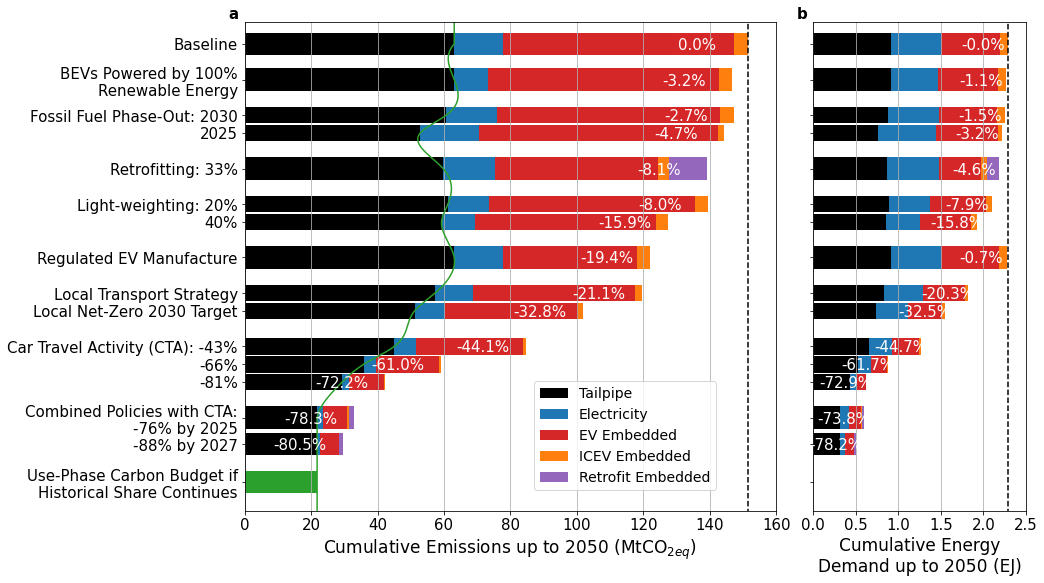

In [7]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

x=["Baseline","BEVs Powered by 100%\nRenewable Energy","Fossil Fuel Phase-Out: 2030", "2025","Retrofitting: 33%",
   "Light-weighting: 20%","40%", "Regulated EV Manufacture",
   "Local Transport Strategy","Local Net-Zero 2030 Target","Car Travel Activity (CTA): -43%","-66%","-81%",
   "Combined Policies with CTA:\n-76% by 2025","-88% by 2027","Use-Phase Carbon Budget if\nHistorical Share Continues"]

electric=[base[6][-1],base_ren[6][-1],p3030[6][-1],p2525[6][-1],third_rf[6][-1],lw_20[6][-1],lw_40[6][-1],base_eu[6][-1],mts1[6][-1],mts2[6][-1],d4343[6][-1],d6666[6][-1],d8181[6][-1],extreme1[6][-1],extreme2[6][-1],0]
elec=((np.array(electric)))

tailpipe=[base[7][-1],base_ren[7][-1],p3030[7][-1],p2525[7][-1],third_rf[7][-1],lw_20[7][-1],lw_40[7][-1],base_eu[7][-1],mts1[7][-1],mts2[7][-1],d4343[7][-1],d6666[7][-1],d8181[7][-1],extreme1[7][-1],extreme2[7][-1],0]
tail=((np.array(tailpipe)))

ev_prod=[base[8][-1],base_ren[8][-1],p3030[8][-1],p2525[8][-1],third_rf[8][-1],lw_20[8][-1],lw_40[8][-1],base_eu[8][-1],mts1[8][-1],mts2[8][-1],d4343[8][-1],d6666[8][-1],d8181[8][-1],extreme1[8][-1],extreme2[8][-1],0]
ev=((np.array(ev_prod)))

ice_prod=[base[9][-1],base_ren[9][-1],p3030[9][-1],p2525[9][-1],third_rf[9][-1],lw_20[9][-1],lw_40[9][-1],base_eu[9][-1],mts1[9][-1],mts2[9][-1],d4343[9][-1],d6666[9][-1],d8181[9][-1],extreme1[9][-1],extreme2[9][-1],0]
ice=((np.array(ice_prod)))

converted=[base[10][-1],base_ren[10][-1],p3030[10][-1],p2525[10][-1],third_rf[10][-1],lw_20[10][-1],lw_40[10][-1],base_eu[10][-1],mts1[10][-1],mts2[10][-1],d4343[10][-1],d6666[10][-1],d8181[10][-1],extreme1[10][-1],extreme2[10][-1],0]
conv=((np.array(converted)))

carbon_budg=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21.7]
cb=((np.array(carbon_budg)))

electric1=[base[18][-1],base_ren[18][-1],p3030[18][-1],p2525[18][-1],third_rf[18][-1],lw_20[18][-1],lw_40[18][-1],base_eu[18][-1],mts1[18][-1],mts2[18][-1],d4343[18][-1],d6666[18][-1],d8181[18][-1],extreme1[18][-1],extreme2[18][-1],0]
elec1=((np.array(electric1))/10**12)

tailpipe1=[base[19][-1],base_ren[19][-1],p3030[19][-1],p2525[19][-1],third_rf[19][-1],lw_20[19][-1],lw_40[19][-1],base_eu[19][-1],mts1[19][-1],mts2[19][-1],d4343[19][-1],d6666[19][-1],d8181[19][-1],extreme1[19][-1],extreme2[19][-1],0]
tail1=((np.array(tailpipe1))/10**12)

ev_prod1=[base[20][-1],base_ren[20][-1],p3030[20][-1],p2525[20][-1],third_rf[20][-1],lw_20[20][-1],lw_40[20][-1],base_eu[20][-1],mts1[20][-1],mts2[20][-1],d4343[20][-1],d6666[20][-1],d8181[20][-1],extreme1[20][-1],extreme2[20][-1],0]
ev1=((np.array(ev_prod1))/10**12)

ice_prod1=[base[21][-1],base_ren[21][-1],p3030[21][-1],p2525[21][-1],third_rf[21][-1],lw_20[21][-1],lw_40[21][-1],base_eu[21][-1],mts1[21][-1],mts2[21][-1],d4343[21][-1],d6666[21][-1],d8181[21][-1],extreme1[21][-1],extreme2[21][-1],0]
ice1=((np.array(ice_prod1))/10**12)

converted1=[base[22][-1],base_ren[22][-1],p3030[22][-1],p2525[22][-1],third_rf[22][-1],lw_20[22][-1],lw_40[22][-1],base_eu[22][-1],mts1[22][-1],mts2[22][-1],d4343[22][-1],d6666[22][-1],d8181[22][-1],extreme1[22][-1],extreme2[22][-1],0]
conv1=((np.array(converted1))/10**12)


per=((elec+tail+ev+ice+conv-(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]))/(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]))*100
per1=((elec1+tail1+ev1+ice1+conv1-(base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12)/((base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12))*100


fig, axs = plt.subplots(1,2,figsize=(14,9),sharey=True,sharex=False, gridspec_kw={'width_ratios': [5, 2]})

# horizontal space between axes
fig.subplots_adjust(wspace=0.1)

pos = [0,1.6,3.2,4,5.6,7.2,8,9.6,11.2,12,13.6,14.4,15.2,16.8,18,19.7]
width = [1,1,0.75,0.75,1,0.75,0.75,1,0.75,0.75,0.75,0.75,0.75,1,1,1]
error=np.random.rand(8)

axs[0].grid(axis='x')
axs[0].barh(pos,tail,width,color=['black'], align='center',label='Tailpipe')
axs[0].barh(pos,elec,width,tail,color=['tab:blue'], align='center',label='Electricity')
axs[0].barh(pos,ev,width,elec+tail,color=['tab:red'], align='center',label='EV Embedded',alpha=1)
axs[0].barh(pos,ice,width,elec+tail+ev,color=['tab:orange'], align='center',label='ICEV Embedded')
axs[0].barh(pos,conv,width,elec+tail+ev+ice,color=['tab:purple'], align='center',label='Retrofit Embedded')
axs[0].barh(pos,cb,width,elec+tail+ev+ice+conv,color=['tab:green'], align='center')

axs[0].legend(bbox_to_anchor=(0.9,0.28), prop={'size': 14})
axs[0].set_xlim(0,160)
axs[0].set_ylim(-1,21)

axs[0].set_xlabel('Cumulative Emissions up to 2050 (MtCO$_{2eq}$)')
axs[0].invert_yaxis()
axs[0].set_yticks(pos)
axs[0].set_yticklabels(x)
axs[0].invert_yaxis()
axs[0].plot([(base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1]), (base[6][-1]+base[7][-1]+base[8][-1]+base[9][-1]+base[10][-1])], [-2,24], "k--")
#axs[0].plot([21.7,21.7], [-2,24], "k--",color='black')
axs[0].text(-0.03, 1, 'a', transform=axs[0].transAxes,fontsize='medium', va='bottom',weight="bold")

from scipy.interpolate import make_interp_spline

x_new = np.linspace(0, 16.8, 300)
a_BSpline = make_interp_spline(pos[0:16],np.array(tail)[0:16])
y_new = a_BSpline(x_new)



axs[0].plot([63.08470628110841]+list(y_new)+[21.80],[-1]+list(x_new)+[21.7],color='tab:green', alpha=1)

axs[0].set_yticks(pos)
axs[0].set_yticklabels(x)


axs[1].barh(pos,tail1,width,color=['black'], align='center',label='Tailpipe')
axs[1].barh(pos,elec1,width,tail1,color=['tab:blue'], align='center',label='Electricity')
axs[1].barh(pos,ev1,width,elec1+tail1,color=['tab:red'], align='center',label='EV Embedded')
axs[1].barh(pos,ice1,width,elec1+tail1+ev1,color=['tab:orange'], align='center',label='ICEV Embedded')
axs[1].barh(pos,conv1,width,elec1+tail1+ev1+ice1,color=['tab:purple'], align='center',label='Retrofit Embedded')
axs[1].grid(axis='x')
axs[1].set_xlabel('Cumulative Energy\nDemand up to 2050 (EJ)')
axs[1].set_yticks(pos)
axs[1].set_yticklabels(x)
axs[1].plot([(base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12, (base[18][-1]+base[19][-1]+base[20][-1]+base[21][-1]+base[22][-1]+base[23][-1])/10**12], [-2,24], "k--")
axs[1].text(-0.08, 1, 'b', transform=axs[1].transAxes,fontsize='medium', va='bottom',weight="bold")
axs[1].set_xticks(np.arange(0,3,0.5))

"""
for i, v in enumerate(elec+tail+ev+ice+conv):
    if i<15:
        axs[0].text(v-21,pos[i]+0.25, '{:.1f}%'.format(per[i]))
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1
"""
for i, v in enumerate(elec+tail+ev+ice+conv):
    if i<15:
        axs[0].text(v-21,pos[i]+0.25, '{:.1f}%'.format(per[i]),color='white')
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1

for i, v in enumerate(elec1+tail1+ev1+ice1+conv1):
    if i<15:
        axs[1].text(v-0.55,pos[i]+0.25, '{:.1f}%'.format(per1[i]),color='white')
        #plt.text(130,pos[i]+0.1, '{:.1f}%'.format(per[i]))
        #v+1 
        
plt.gca().invert_yaxis()
plt.savefig('Fig1.pdf', bbox_inches="tight")
plt.savefig('Fig1.png', bbox_inches="tight")
plt.show()